In [31]:
# Global imports 
import os
import json
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from itertools import cycle
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.dates import DateFormatter, YearLocator
from scipy.spatial.distance import euclidean, pdist, squareform

# Helper functions import 
from src.utils.helpers_RQ2 import *

# Cleaning functions import
from src.data.clean_df_channels import clean_data
from src.data.clean_metadata import clean_feather
from src.data.clean_timeseries import clean_timeseries_data
from src.data.clean_numcomments import remove_missing_comments


In [22]:
plt.style.use("seaborn-v0_8")
sns.set_theme(style="ticks")
sns.set_palette("husl")

# Load the datasets

In [25]:
data_path = "data"
df_channels_en = pd.read_csv(os.path.join(data_path, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
df_timeseries_en = pd.read_csv(os.path.join(data_path, "df_timeseries_en.tsv.gz"), compression="infer", sep="\t")
num_comments = pd.read_csv(os.path.join(data_path, "num_comments.tsv.gz"), compression="infer", sep="\t")
num_comments_authors = pd.read_csv(os.path.join(data_path, "num_comments_authors.tsv.gz"), compression="infer", sep="\t")
video_meta = pd.read_feather(os.path.join(data_path, "yt_metadata_helper.feather"))

# Data cleaning

/opt/anaconda3/envs/ada/lib/python3.13/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


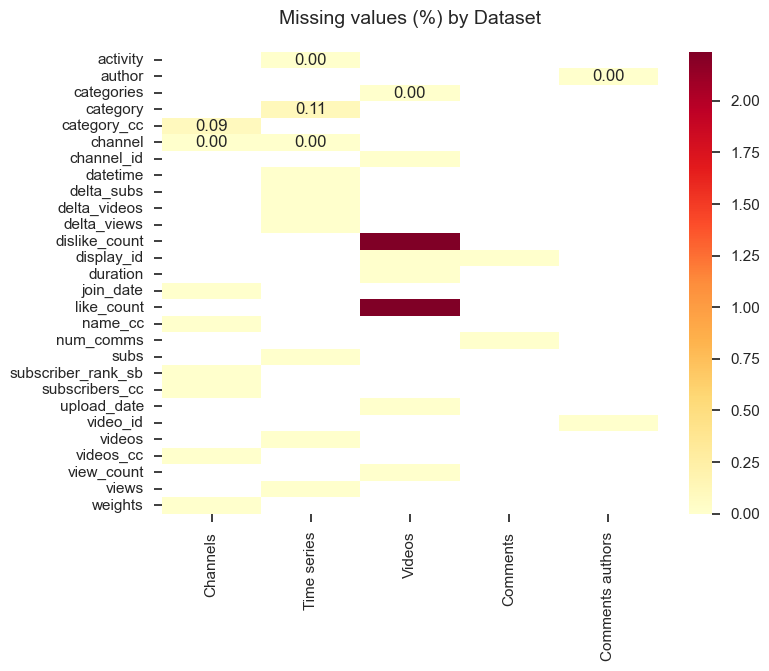

In [26]:
# Missing data
plt.figure(figsize=(8, 6))
missing_data = pd.DataFrame({
    "Channels": df_channels_en.isna().sum() / len(df_channels_en) * 100,
    "Time series": df_timeseries_en.isna().sum() / len(df_timeseries_en) * 100,
    "Videos": video_meta.isna().sum() / len(video_meta) * 100,
    "Comments": num_comments.isna().sum() / len(num_comments) * 100,
    "Comments authors": num_comments_authors.isna().sum() / len(num_comments_authors) * 100
})
sns.heatmap(missing_data, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Missing values (%) by Dataset", fontsize=14, pad=20)
plt.show()

The amount of missing data is not significant : 2.24% in videos (most of the missing data is in the dislike_count and like_count columns), 0.11% in timeseries and 0.09% in channels.

We can apply a cleaning step to remove missing data from the datasets.

Additional cleaning steps are performed at each section of the analysis.

In [ ]:
clean_data(os.path.join(data_path, "df_channels_en.tsv.gz"), os.path.join(data_path, "df_channels_cleaned.csv"))
clean_feather(os.path.join(data_path, "yt_metadata_helper.feather"), os.path.join(data_path, "yt_metadata_cleaned.csv"))
clean_timeseries_data(os.path.join(data_path, "df_timeseries_en.tsv.gz"), os.path.join(data_path, "df_timeseries_en_cleaned.csv"))
remove_missing_comments(os.path.join(data_path, "num_comments.tsv.gz"), os.path.join(data_path, "num_comments_cleaned.csv"))

In [34]:
df_channels_en_cleaned = df_channels_en.dropna(axis=0)
df_timeseries_en_cleaned = df_timeseries_en.dropna(axis=0)
video_meta_cleaned = video_meta.dropna(axis=0)
num_comments_cleaned = num_comments.dropna(axis=0)
num_comments_authors_cleaned = num_comments_authors.dropna(axis=0)

# Exploratory Data Analysis

We started the analysis by visualizing the size of the youniverse datasets plotted on a logarithmic scale. 

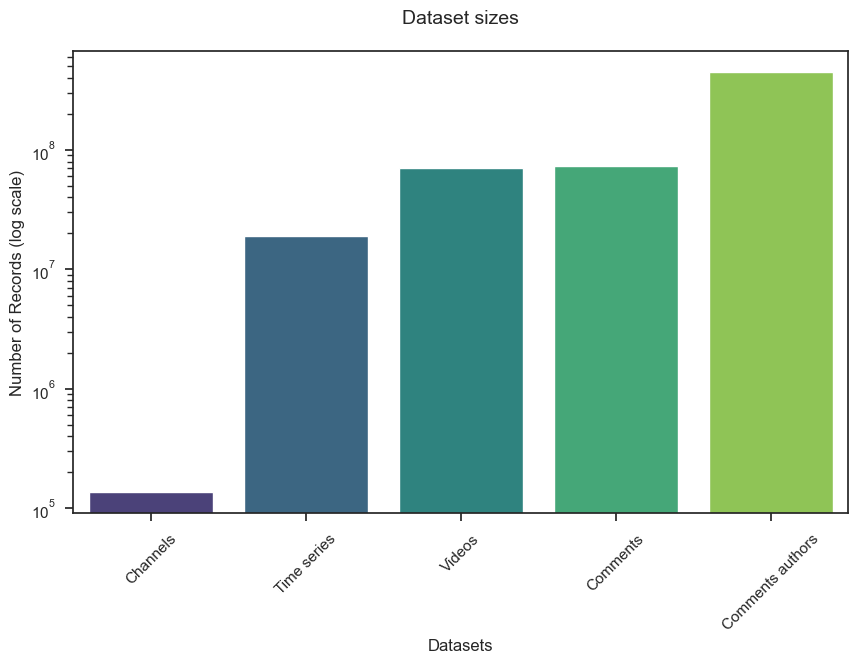

In [35]:
#  Dataset overview
plt.figure(figsize=(10, 6))
dataset_sizes = pd.Series({
    "Channels": len(df_channels_en_cleaned),
    "Time series": len(df_timeseries_en_cleaned),
    "Videos": len(video_meta_cleaned),
    "Comments": len(num_comments_cleaned),
    "Comments authors": len(num_comments_authors_cleaned)
})
sns.barplot(x=dataset_sizes.index, y=dataset_sizes.values, palette="viridis")
plt.title("Dataset sizes", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel("Number of Records (log scale)", fontsize=12)
plt.xlabel("Datasets", fontsize=12)

plt.show()

1. Channels dataset is the smallest, with 136470 records
2. Time series data contains 18872499 records
3. Videos dataset has 72924794 records
4. Comments dataset contains 72924794 records as well
5. Comments authors dataset is the largest with 448810483 records

The logarithmic scale (y-axis) helps visualize these widely varying dataset sizes, spanning from hundreds of thousands to hundreds of millions of records

### Univariate analysis

We perform a univariate analysis on the cleaned datasets to get a first overview of the data.
We will plot the distribution of the following metrics:
- Subscribers distribution
- Videos count distribution
- Category distribution
- View count distribution
- Duration distribution
- Likes distribution
- Dislikes distribution
- Comment count per video
- Comment count per user

/opt/anaconda3/envs/ada/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ada/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ada/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ada/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

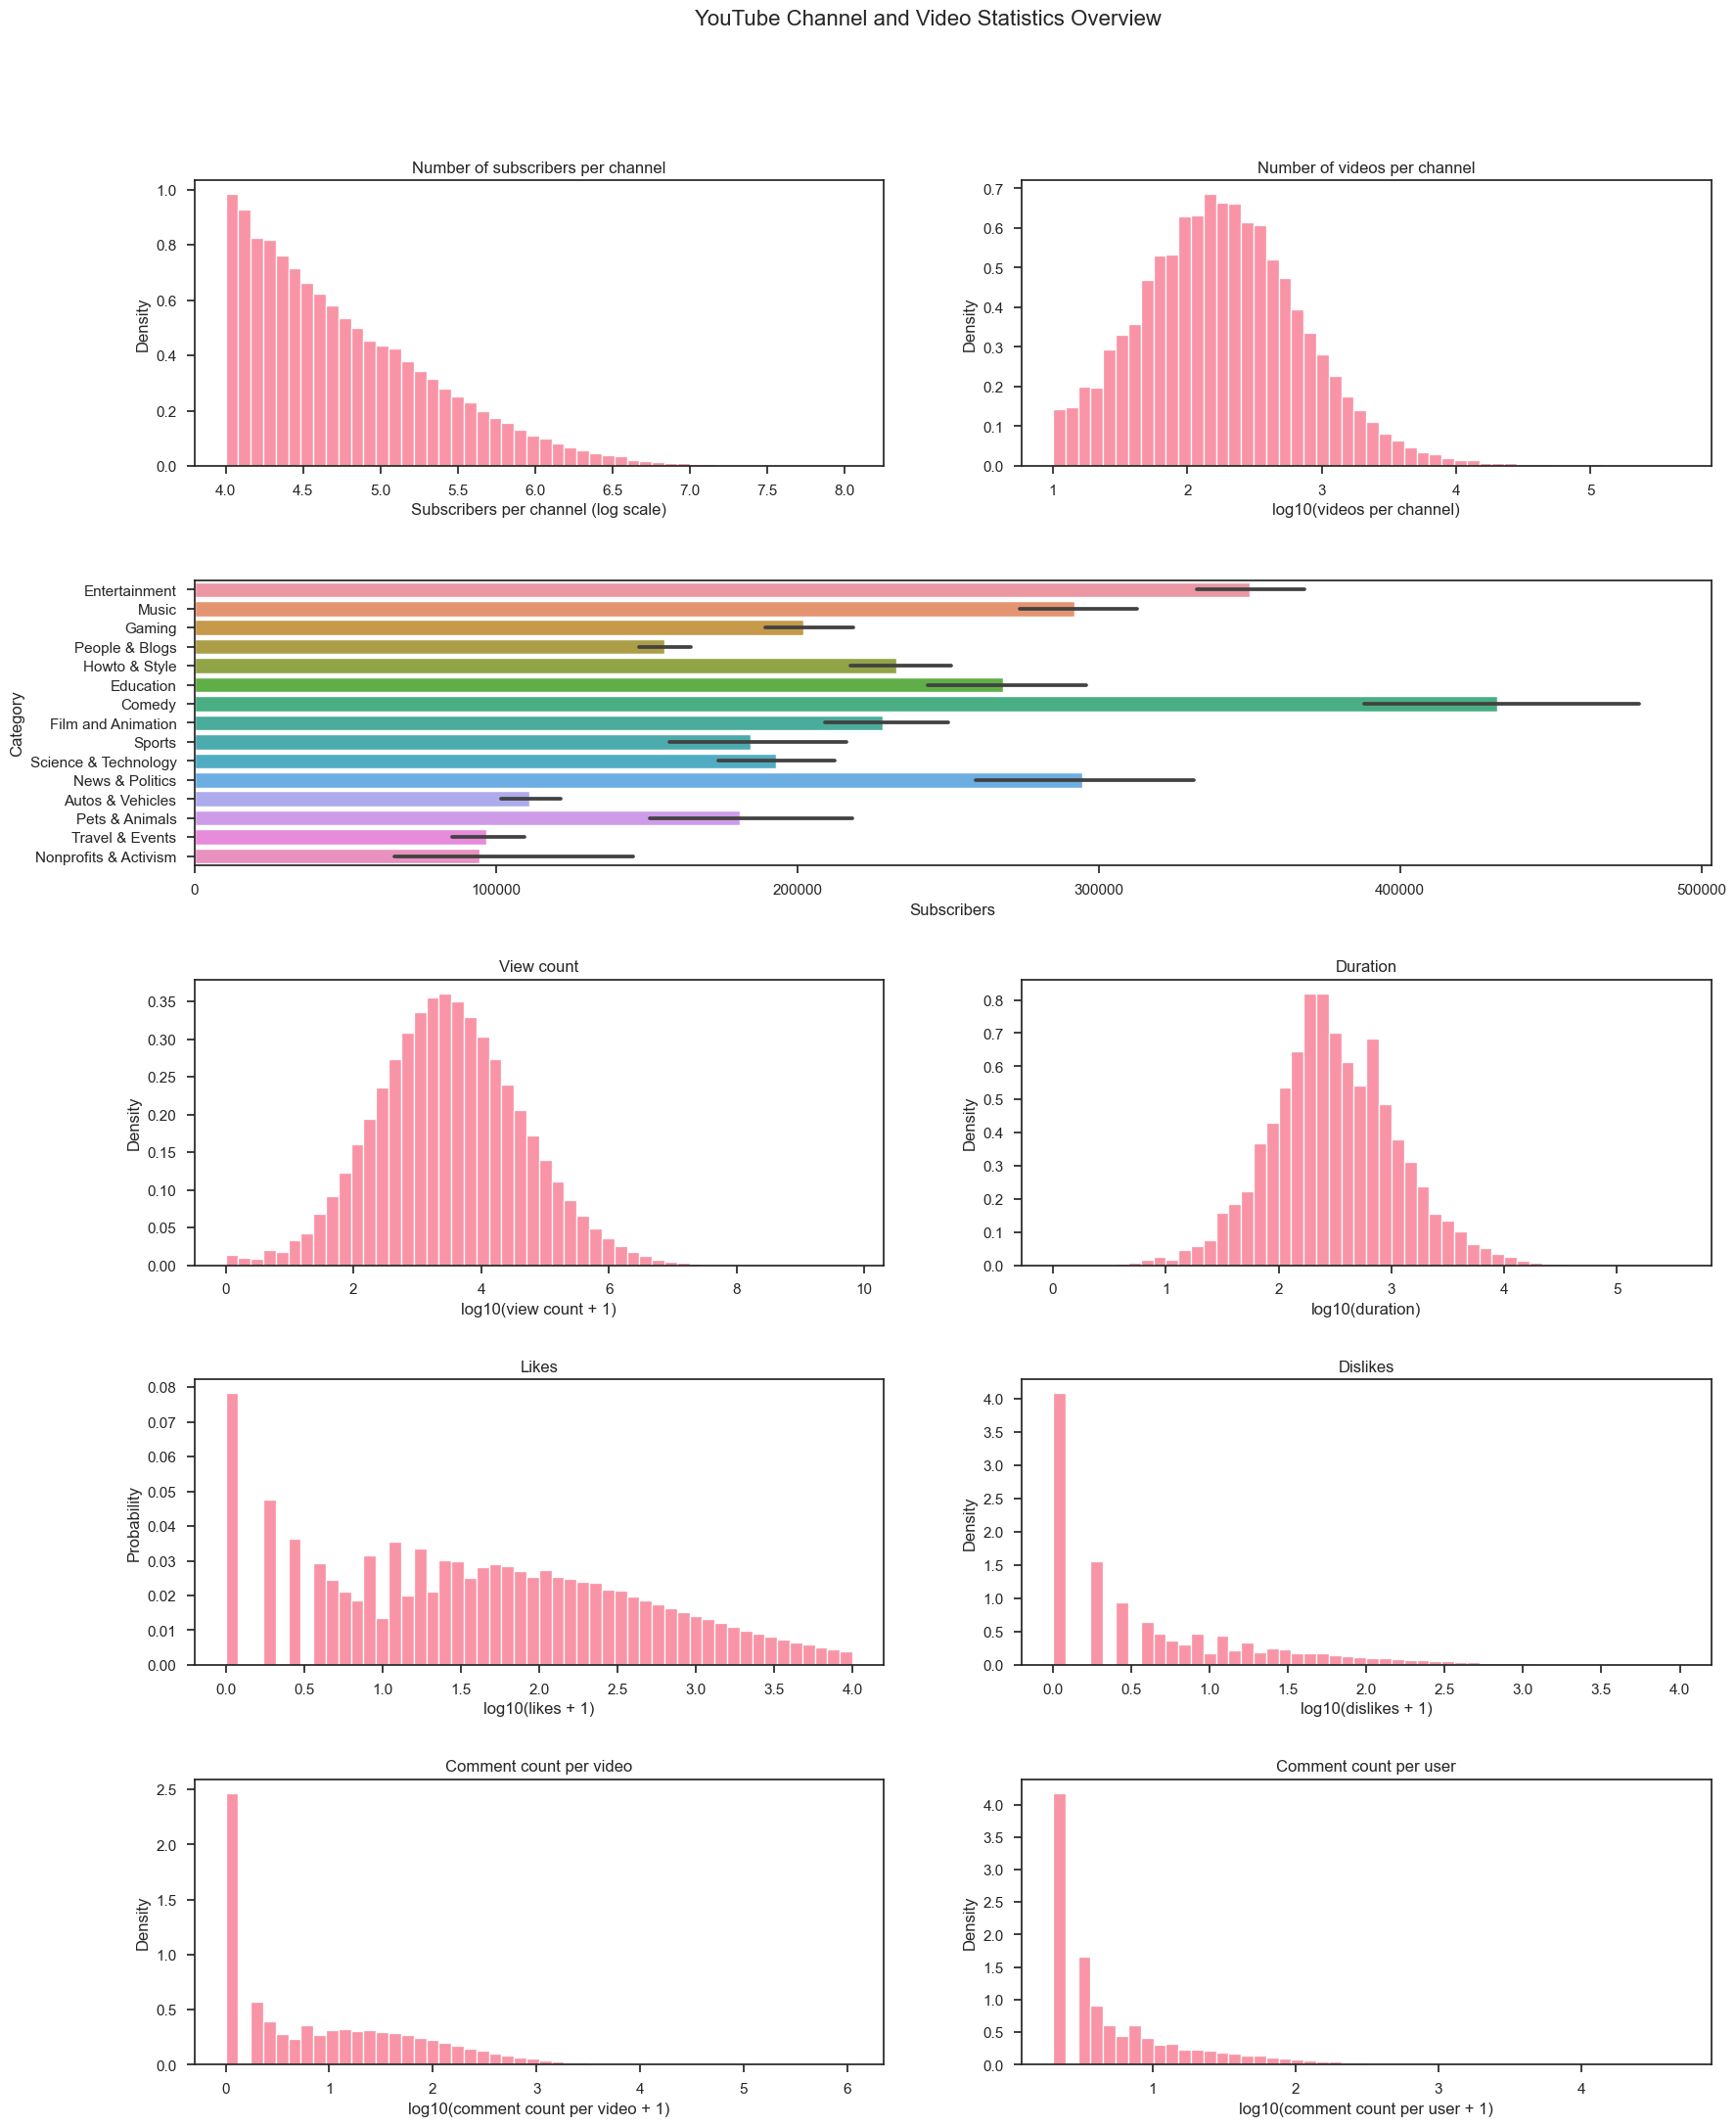

In [36]:
# Create figure and grid
fig = plt.figure(figsize=(20, 25))
gs = fig.add_gridspec(5, 2, hspace=0.4)

# 1. Subscribers distribution
ax1 = fig.add_subplot(gs[0, 0])
num_subs_cc = np.log10(df_channels_en_cleaned["subscribers_cc"])
sns.histplot(num_subs_cc, stat="density", kde=False, bins=50, ax=ax1)
ax1.set_title("Number of subscribers per channel")
ax1.set_xlabel("Subscribers per channel (log scale)")

# 2. Video count distribution
ax2 = fig.add_subplot(gs[0, 1])
num_videos_cc = np.log10(df_channels_en_cleaned["videos_cc"])
sns.histplot(num_videos_cc, stat="density", kde=False, bins=50, ax=ax2)
ax2.set_title("Number of videos per channel")
ax2.set_xlabel("log10(videos per channel)")

# 3. Category distribution
ax3 = fig.add_subplot(gs[1, :])
category_order = df_channels_en_cleaned.groupby("category_cc")["subscribers_cc"].sum().sort_values(ascending=False).index
sns.barplot(data=df_channels_en_cleaned, x="subscribers_cc", y="category_cc", 
            orient="h", order=category_order, ax=ax3)
ax3.set_xlabel("Subscribers")
ax3.set_ylabel("Category")

# 4. View count distribution
ax4 = fig.add_subplot(gs[2, 0])
view_count = np.log10(video_meta_cleaned["view_count"] + 1)
sns.histplot(view_count, stat="density", kde=False, bins=50, ax=ax4)
ax4.set_title("View count")
ax4.set_xlabel("log10(view count + 1)")

# 5. Duration distribution
ax5 = fig.add_subplot(gs[2, 1])
duration = np.log10(video_meta_cleaned["duration"])
sns.histplot(duration, stat="density", kde=False, bins=50, ax=ax5)
ax5.set_title("Duration")
ax5.set_xlabel("log10(duration)")

# 6. Like distribution
ax6 = fig.add_subplot(gs[3, 0])
like = np.log10(video_meta_cleaned["like_count"] + 1)
sns.histplot(like, stat="probability", kde=False, bins=50, binrange=(0, 4), ax=ax6)
ax6.set_title("Likes")
ax6.set_xlabel("log10(likes + 1)")

# 7. Dislike distribution
ax7 = fig.add_subplot(gs[3, 1])
dislike = np.log10(video_meta_cleaned["dislike_count"] + 1)
sns.histplot(dislike, stat="density", kde=False, bins=50, binrange=(0, 4), ax=ax7)
ax7.set_title("Dislikes")
ax7.set_xlabel("log10(dislikes + 1)")

# 8. Comment count per video
ax8 = fig.add_subplot(gs[4, 0])
comment_count = np.log10(num_comments_cleaned["num_comms"] + 1)
sns.histplot(comment_count, stat="density", kde=False, bins=50, ax=ax8)
ax8.set_title("Comment count per video")
ax8.set_xlabel("log10(comment count per video + 1)")

# 9. Comment count per user
ax9 = fig.add_subplot(gs[4, 1])
comment_count_author = np.log10(num_comments_authors_cleaned["video_id"].head(1000000) + 1)
sns.histplot(comment_count_author, stat="density", kde=False, bins=50, ax=ax9)
ax9.set_title("Comment count per user")
ax9.set_xlabel("log10(comment count per user + 1)")

# Add a main title
fig.suptitle("YouTube Channel and Video Statistics Overview", fontsize=16, y=0.95)

# Adjust layout
plt.tight_layout()
plt.show()

The univariate analysis reveals several interesting patterns about how content and engagement are distributed on the platform:

- For channels and their characteristics:
Most YouTube channels have between 10,000 to 100,000 subscribers, with very few reaching the millions. This follows a classic power law distribution where success is heavily concentrated among a small percentage of creators. The number of videos per channel peaks around 300, suggesting this might be a sustainable production level for active creators. Very few channels exceed 10,000 videos, indicating natural limits to content production capacity.

- Entertainment, Music, and Gaming dominate in terms of subscriber numbers, followed by lifestyle and educational content (People & Blogs, Science & Technology). Nonprofits, Activism, and Pets & Animals tend to have smaller audiences, reflecting general user preferences and mainstream entertainment trends.

- Looking at video performance metrics:
The typical video gets around 10,000 views, though there's enormous variation. The distribution of views shows the viral potential of the platform, while most content gets moderate attention, some videos reach hundreds of millions of views. Video length clusters around 5 minutes, likely reflecting both audience attention spans and platform optimization strategies.

- Engagement patterns are particularly telling:
Both likes and dislikes show extreme concentration, many videos get very few interactions while a tiny fraction receives massive engagement. Dislikes are consistently less common than likes across the board. The commenting behavior follows similar patterns: most videos receive few comments, and most users comment infrequently. The sharp dropoff in comment frequency per user suggests that casual, one-time engagement is the norm rather than sustained participation.

These patterns reflect both human behavior (tendency to gravitate toward popular content) and platform dynamics (algorithmic content promotion, sustainable content creation practices). They paint a picture of YouTube as a hit-driven platform where breakthrough success is rare but potentially massive in scale.

---
---

# RQ1: Analysis of YouTube Content Creation Evolution

This notebook explores the frequency and consistency of content creation across different YouTube channel categories over time, using the YouNiverse dataset. It serves as an introduction to our project to analyse the evolution of YouTube as a platform, who grew over the years to become one of the biggest platforms on the web.

The evolution of YouTube into a professionalized platform has been marked by the rise of full-time content creators who adopt strategic practices to grow and sustain their audiences. Among these practices, content upload frequency and consistency play a pivotal role in determining a channel's success and its ability to engage audiences over time.

Audience Expectations and Retention:

- Regular uploads build a habit for viewers and establish trust. Consistency in content creation allows creators to maintain audience engagement, leading to greater loyalty and retention. In contrast, sporadic uploads can disrupt audience growth and hinder a channel’s long-term viability.

Algorithmic Promotion:

- YouTube's recommendation algorithms favor channels that upload frequently and consistently, as regular uploads increase the chances of videos being shown to viewers. This is particularly important for driving growth in views, likes, and subscribers.

Indicators of Professionalization:

- Professional content creators often adopt structured upload schedules, mimicking practices seen in traditional media industries. Increased upload frequency and consistency are hallmarks of creators who treat content creation as a full-time career rather than a hobby.

Category-Specific Growth Trends:

- Different content categories (e.g., Gaming, Education, Music) have played unique roles in YouTube's evolution. By analyzing how upload patterns vary across these categories, we can identify which types of content drive the platform's growth and how creators adapt their strategies to meet audience demands.

Tracking Growth Over Time:

- Understanding how upload patterns have changed over the years helps us map YouTube’s transformation into a platform where strategic content creation drives audience engagement and platform growth.


This frequency and consistency analysis provides empirical evidence to support our investigation into YouTube’s professionalization. By analyzing upload behaviors across categories and time, we aim to uncover trends that illustrate YouTube's shift into a platform capable of supporting full-time careers.

In [13]:
ROOT_DIR = Path.cwd().parent.parent

# Load the datasets
channel_data = pd.read_csv(ROOT_DIR / "data" / "df_channels_en_with_monetization.csv", dtype={
        'has_affiliate': 'boolean',
        'has_sponsorships': 'boolean',
        'has_merchandise': 'boolean'
    })

video_data = pd.read_feather(ROOT_DIR / "data" / "yt_metadata_helper.feather")

In [14]:
channel_data.head(5)

category_cc   join_date                   channel  \
0         Gaming  2010-04-29  UC-lHJZR3Gqxm24_Vd_AJ5Yw   
1      Education  2006-09-01  UCbCmjCuTUZos6Inko4u57UQ   
2  Entertainment  2006-09-20  UCpEhnqL0y41EpW2TvWAHD7Q   
3  Howto & Style  2016-11-15  UC295-Dw_tDNtZXFeAPAW6Aw   
4         Sports  2007-05-11  UCJ5v_MCY6GNUBTO8-D3XoAg   

                   name_cc  subscribers_cc  videos_cc  subscriber_rank_sb  \
0                PewDiePie       101000000       3956                 3.0   
1  Cocomelon - Nursery ...        60100000        458                 7.0   
2                SET India        56018869      32661                 8.0   
3          5-Minute Crafts        60600000       3591                 9.0   
4                      WWE        48400000      43421                11.0   

   weights  lowest_monthly_earnings  highest_monthly_earnings  \
0    2.087                   9800.0                  156700.0   
1    2.087                      NaN                       NaN   
2    2.087                      NaN                       NaN   
3    2.087                      0.0                       0.0   
4    2.087                 178700.0                 2900000.0   

   lowest_yearly_earnings  highest_yearly_earnings  has_affiliate  \
0                117600.0               1900000.00           <NA>   
1                     NaN                      NaN           <NA>   
2                     NaN                      NaN          False   
3                     0.0                     0.05          False   
4               2100000.0              34300000.00          False   

   has_sponsorships  has_merchandise  
0              <NA>             <NA>  
1              <NA>             <NA>  
2             False             True  
3             False            False  
4             False            False

In [15]:
video_data.head(5)

categories                channel_id  dislike_count   display_id  \
0  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA            1.0  SBqSc91Hn9g   
1  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA            1.0  UuugEl86ESY   
2  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA          779.0  oB4c-yvnbjs   
3  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA           24.0  ZaV-gTCMV8E   
4  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA           13.0  cGvL7AvMfM0   

   duration  like_count upload_date  view_count  
0      1159         8.0  2016-09-28      1057.0  
1      2681        23.0  2016-09-28     12894.0  
2      1394      1607.0  2016-09-28   1800602.0  
3      5064       227.0  2016-09-28     57640.0  
4      3554       105.0  2016-09-28     86368.0

In [16]:
channel_data['join_date'] = pd.to_datetime(channel_data['join_date'])
video_data['upload_date'] = pd.to_datetime(video_data['upload_date'])

In [17]:
channel_data.isna().sum()

category_cc                    128
join_date                        1
channel                          0
name_cc                         10
subscribers_cc                   0
videos_cc                        0
subscriber_rank_sb               0
weights                          0
lowest_monthly_earnings     136175
highest_monthly_earnings    136175
lowest_yearly_earnings      136175
highest_yearly_earnings     136175
has_affiliate               101062
has_sponsorships            101062
has_merchandise             101062
dtype: int64

We might want to remove samples that have NaN category and/or NaN name.

In [18]:
channel_data.shape

(136470, 15)

In [19]:
# Remove samples that have no category and/or name
channel_data = channel_data.dropna(subset=['category_cc', 'name_cc'])

In [20]:
# New shape after removing samples
channel_data.shape

(136332, 15)

In [21]:
video_data.isna().sum()

categories             0
channel_id             0
dislike_count    1631458
display_id             0
duration               0
like_count       1631458
upload_date            0
view_count           654
dtype: int64

In [22]:
video_data = video_data.dropna()

In [23]:
video_data.shape

(71293336, 8)

In [24]:
# Add year and month columns of upload date of the video data to facilitate time-based analysis
video_data['year'] = video_data['upload_date'].dt.year
video_data['month'] = video_data['upload_date'].dt.to_period('M')

In [25]:
# Merge with channel metadata if needed
channel_video_data = video_data.merge(
    channel_data,
    left_on='channel_id', # Column name in video data
    right_on='channel',   # Column name in channel data
    how='inner'
)

In [26]:
channel_video_data = channel_video_data.drop(columns='channel')

In [27]:
channel_video_data = channel_video_data.rename(
    columns={
        'categories': 'video_category',
        'category_cc': 'channel_category'
    }
)

In [28]:
channel_video_data.columns

Index(['video_category', 'channel_id', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count', 'year', 'month',
       'channel_category', 'join_date', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights', 'lowest_monthly_earnings',
       'highest_monthly_earnings', 'lowest_yearly_earnings',
       'highest_yearly_earnings', 'has_affiliate', 'has_sponsorships',
       'has_merchandise'],
      dtype='object')

In [29]:
channel_video_data.head(5)

video_category                channel_id  dislike_count   display_id  \
0  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA            1.0  SBqSc91Hn9g   
1  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA            1.0  UuugEl86ESY   
2  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA          779.0  oB4c-yvnbjs   
3  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA           24.0  ZaV-gTCMV8E   
4  Film & Animation  UCzWrhkg9eK5I8Bm3HfV-unA           13.0  cGvL7AvMfM0   

   duration  like_count upload_date  view_count  year    month  ... videos_cc  \
0      1159         8.0  2016-09-28      1057.0  2016  2016-09  ...      2398   
1      2681        23.0  2016-09-28     12894.0  2016  2016-09  ...      2398   
2      1394      1607.0  2016-09-28   1800602.0  2016  2016-09  ...      2398   
3      5064       227.0  2016-09-28     57640.0  2016  2016-09  ...      2398   
4      3554       105.0  2016-09-28     86368.0  2016  2016-09  ...      2398   

  subscriber_rank_sb weights  lowest_monthly_earnings  \
0            54617.0  3.5155                      NaN   
1            54617.0  3.5155                      NaN   
2            54617.0  3.5155                      NaN   
3            54617.0  3.5155                      NaN   
4            54617.0  3.5155                      NaN   

   highest_monthly_earnings  lowest_yearly_earnings  highest_yearly_earnings  \
0                       NaN                     NaN                      NaN   
1                       NaN                     NaN                      NaN   
2                       NaN                     NaN                      NaN   
3                       NaN                     NaN                      NaN   
4                       NaN                     NaN                      NaN   

   has_affiliate  has_sponsorships  has_merchandise  
0          False             False            False  
1          False             False            False  
2          False             False            False  
3          False             False            False  
4          False             False            False  

[5 rows x 24 columns]

In [30]:
channel_video_data.shape

(71251519, 24)

## Frequency Analysis

We define frequency as the number of uploads made by channels within a given category over a specific time period (e.g., per year, per month). It provides a measure of how often content is being uploaded for each category.

We care about frequency because it shows how active channels in each category are over time and it helps identify which categories are growing or declining in activity. In our case, higher frequencies may indicate more professionalized or competitive categories.


In [31]:
# Calculate the number of uploads per category per year
frequency_analysis = channel_video_data.groupby(['channel_category', 'year', 'month']).size().reset_index(name='upload_count')

print(frequency_analysis.head())

   channel_category  year    month  upload_count
0  Autos & Vehicles  2005  2005-12             1
1  Autos & Vehicles  2006  2006-01             4
2  Autos & Vehicles  2006  2006-02           117
3  Autos & Vehicles  2006  2006-03            29
4  Autos & Vehicles  2006  2006-04            20


#### Yearly Growth per Category

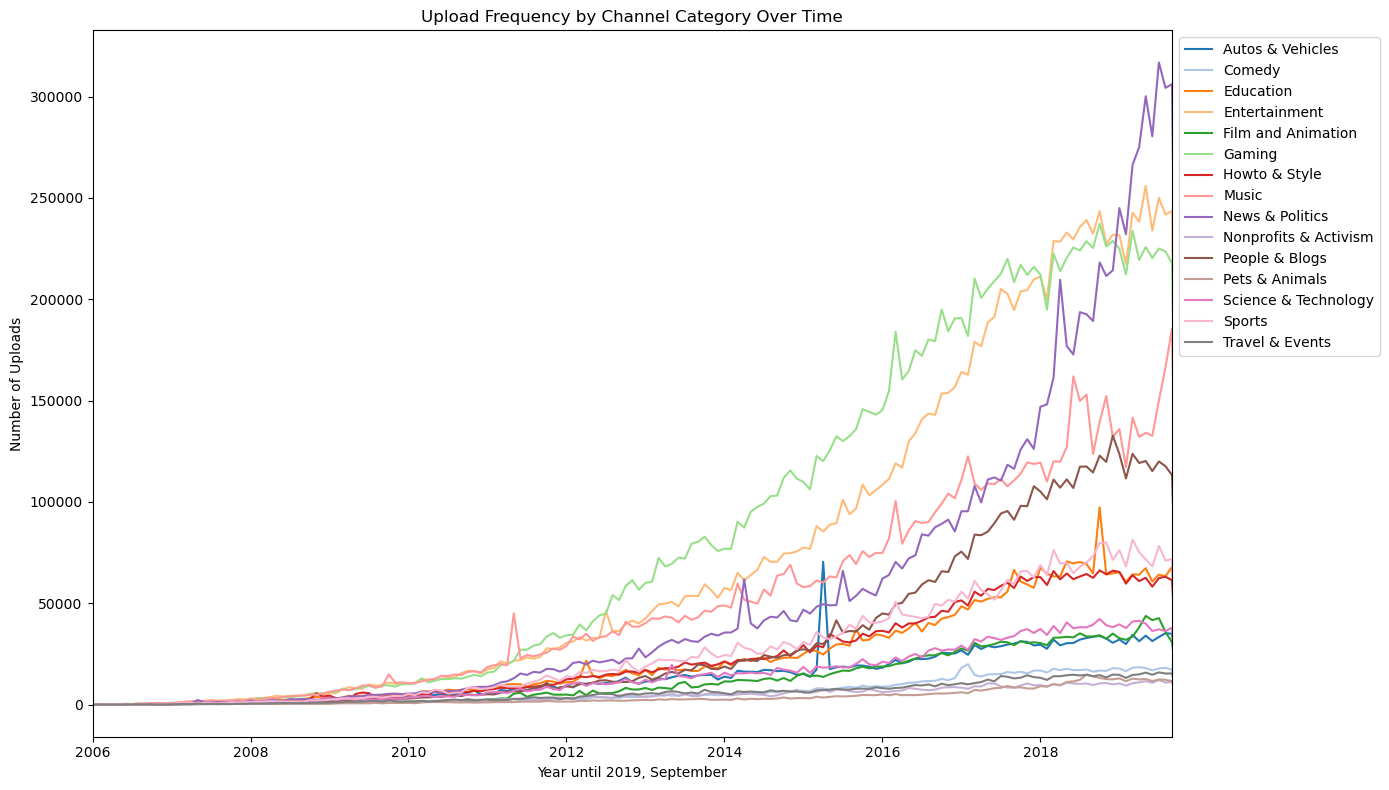

In [32]:
temp_df = frequency_analysis.copy()

temp_df['month'] = frequency_analysis['month'].dt.month
temp_df['time'] = frequency_analysis['year'] + (temp_df['month'] - 1) / 12

# We stop at year 2019, month September because there are almost no data to plot after this date
cutoff_year = 2019 + (9 - 1) / 12

# Define a color cycle with 15 distinct colors
colors = plt.cm.tab20.colors  # Tab20 provides 20 distinct colors
color_cycle = cycle(colors)  # Cycle through the colors

# Plot upload frequencies over time
plt.figure(figsize=(14, 8))
categories = temp_df['channel_category'].unique()

for category in categories:
    subset = temp_df[temp_df['channel_category'] == category]
    plt.plot(subset['time'], subset['upload_count'], label=category, color=next(color_cycle))

# Customize the plot
plt.title("Upload Frequency by Channel Category Over Time")
plt.xlabel("Year until 2019, September")
plt.ylabel("Number of Uploads")
plt.xlim(2006, cutoff_year)  # Limit the x-axis to the range [2006, 2019.91]
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()


This graph showcases the evolution of upload frequency across various YouTube channel categories from 2006 to 2019.

Categories like Gaming, Entertainment, and Music demonstrate the highest and most rapid growth in upload frequency, particularly after 2012. This reflects the rising professionalization within these categories, where creators likely adopted regular upload schedules to engage larger audiences.

The graph illustrates YouTube's shift from casual video sharing to structured, high-frequency content creation. Categories driving this transformation reflect strategic professionalization, where consistent and frequent uploads align with audience demand and algorithmic visibility. This analysis underscores the role of content categories in shaping YouTube into a platform supporting full-time digital careers.

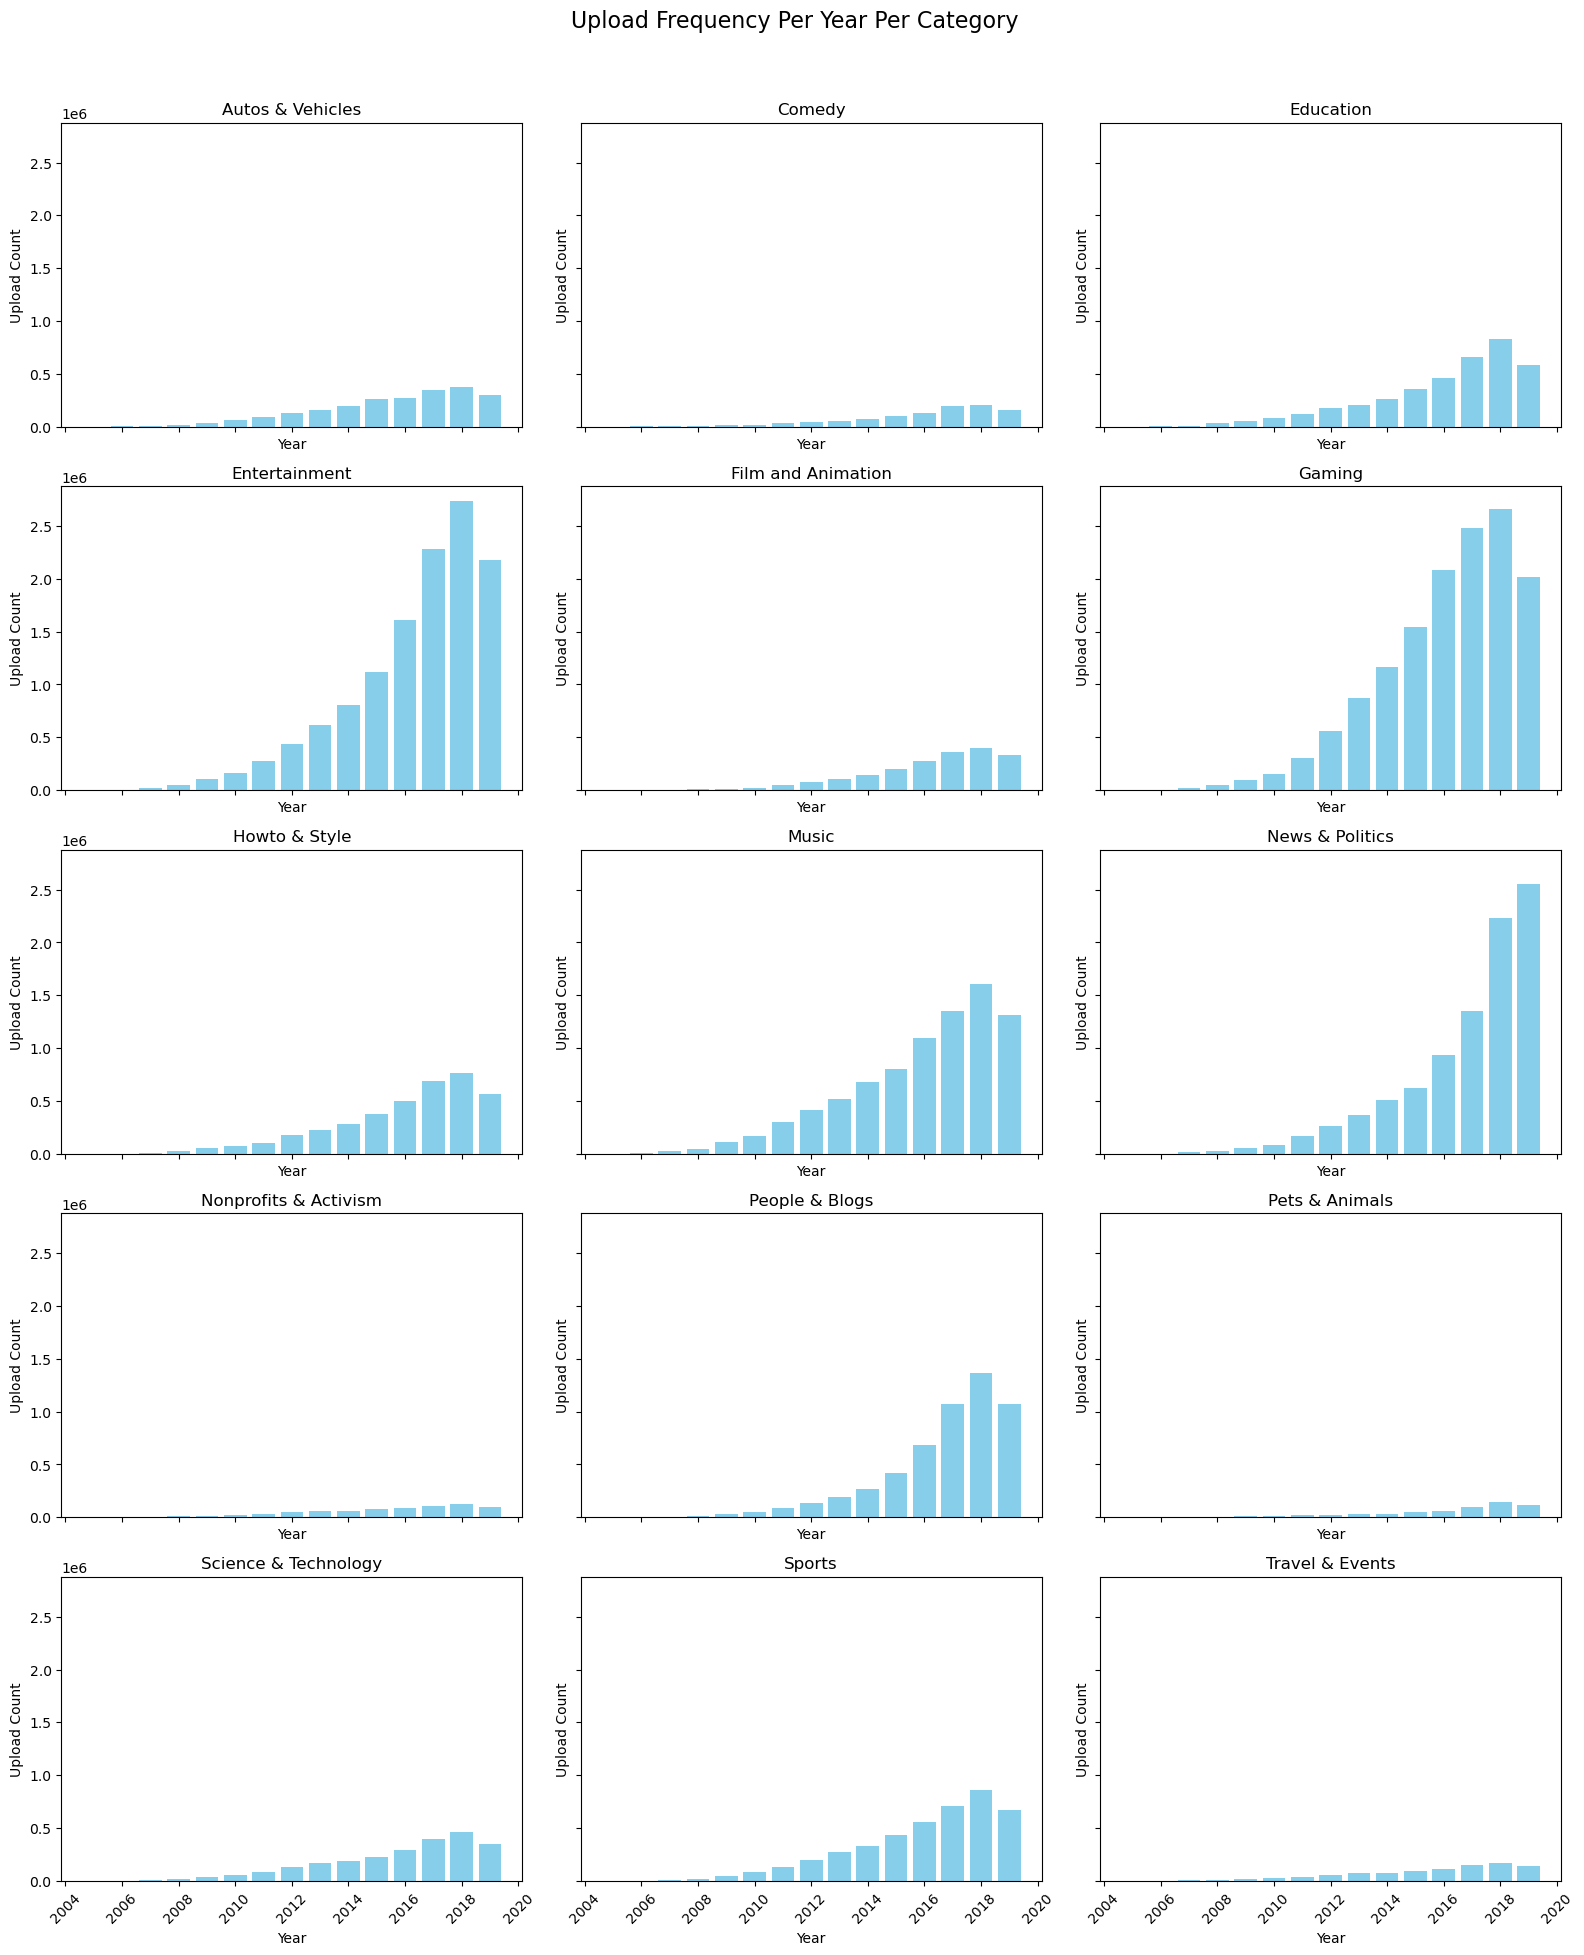

In [33]:
# Group by channel category and year to calculate upload frequency
yearly_frequency = frequency_analysis.groupby(['channel_category', 'year']).agg({'upload_count': 'sum'}).reset_index()

# Get the unique categories
categories = yearly_frequency['channel_category'].unique()

# Number of subplots
n_categories = len(categories)
n_cols = 3
n_rows = 5

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each category in a separate subplot
for i, category in enumerate(categories):
    # Filter data for the category
    category_data = yearly_frequency[yearly_frequency['channel_category'] == category]
    axes[i].bar(category_data['year'], category_data['upload_count'], color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(category)
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Upload Count")
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle("Upload Frequency Per Year Per Category", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The categories that witnessed the biggest upload growth over the years are: Music, News & Politics, Gaming, Entertainment and People & Blog. Their growth might indicate a professionalization that could be correlated with the consistency analysis.

Categories such as Nonprofits & Activism, Autos & Vehicles, and Travel & Events show limited upload activity, reflecting niche or seasonal trends.

Overall, this graph illustrates how YouTube’s growth is largely driven by specific categories, with Gaming, Entertainment, Education and News & Politics emerging as central pillars. This aligns with the platform's transition into a professional career hub, as creators in these categories adopt consistent and frequent upload strategies to engage larger audiences.

#### Upload Frequency per Channel

In [34]:
# Count uploads per channel
channel_uploads = channel_video_data.groupby(['channel_id', 'channel_category']).size().reset_index(name='upload_count')

# Compute average uploads per channel for each category
average_uploads_per_category = channel_uploads.groupby('channel_category')['upload_count'].mean().reset_index(name='avg_uploads_per_channel')

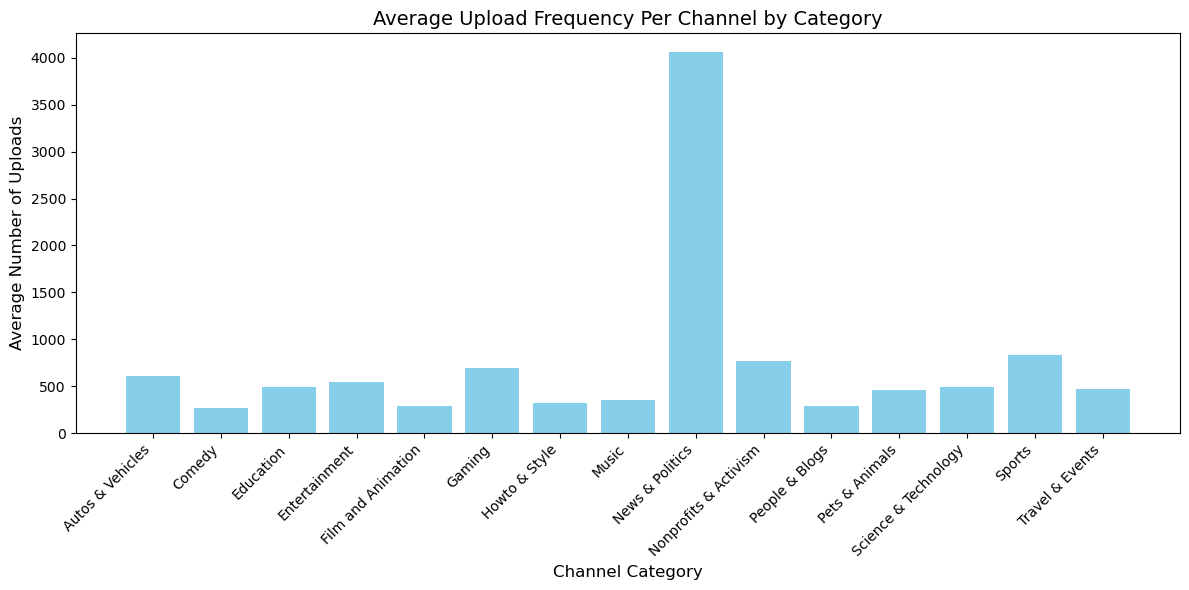

In [35]:
plt.figure(figsize=(12, 6))
plt.bar(average_uploads_per_category['channel_category'], average_uploads_per_category['avg_uploads_per_channel'], color='skyblue')

# Customize the plot
plt.title("Average Upload Frequency Per Channel by Category", fontsize=14)
plt.xlabel("Channel Category", fontsize=12)
plt.ylabel("Average Number of Uploads", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate category names for better readability
plt.tight_layout()

# Show the plot
plt.show()

The category 'News & Politics' exhibits the highest average upload frequency per channel by far. The possible reason for this could be due to the fact that news are time-sensitive content: updates need to be uploaded frequently to stay relevant.

The categories 'Gaming' and 'Sports' also exhibit relatively high upload frequencies.

Analyzing engagement metrics (views, likes, dislikes) would help understand if high upload frequency correlates with better audience engagement for these categories.

#### Relationship with Engagement

We will try to analyse if the frequency of uploads have a relationship with any engagement metrics such as subscribers count, views count, likes count and dislikes count.

##### Channels Engagement

We analyse in this part if engagement metrics with respect to channels have some correlation with upload frequency.

In [36]:
# Aggregate upload frequency, engagement metrics, and additional channel data
channel_engagement = channel_video_data.groupby('channel_id').agg({
    'upload_date': 'count',        # Total uploads (frequency)
    'view_count': 'sum',           # Total views per channel
    'like_count': 'sum',           # Total likes per channel
    'dislike_count': 'sum',        # Total dislikes per channel
    'subscribers_cc': 'first',     # Number of subscribers (assuming it's constant for a channel)
}).reset_index()

# Rename columns for clarity
channel_engagement.rename(columns={
    'upload_date': 'upload_frequency',
    'view_count': 'total_views_per_channel',
    'like_count': 'total_likes_per_channel',
    'dislike_count': 'total_dislikes_per_channel',
    'subscribers_cc': 'subscribers',
}, inplace=True)

print(channel_engagement.head())

                 channel_id  upload_frequency  total_views_per_channel  \
0  UC--24Q3_ZQeFmgJE-Um5QZQ               189                3291383.0   
1  UC--2EbuIuBOGgGqPiJxi3rg                60                7999515.0   
2  UC--3c8RqSfAqYBdDjIG3UNA               333               63626751.0   
3  UC--3ozenTzry39-xMqAPQlw                43                5192527.0   
4  UC--6E6EpybocdaNlPhvK_9A                31                9317278.0   

   total_likes_per_channel  total_dislikes_per_channel  subscribers  
0                  64823.0                      1544.0        17308  
1                  38553.0                      2383.0        13869  
2                 323791.0                     20737.0        73523  
3                  35760.0                       952.0       108000  
4                 226691.0                      6142.0        93900  


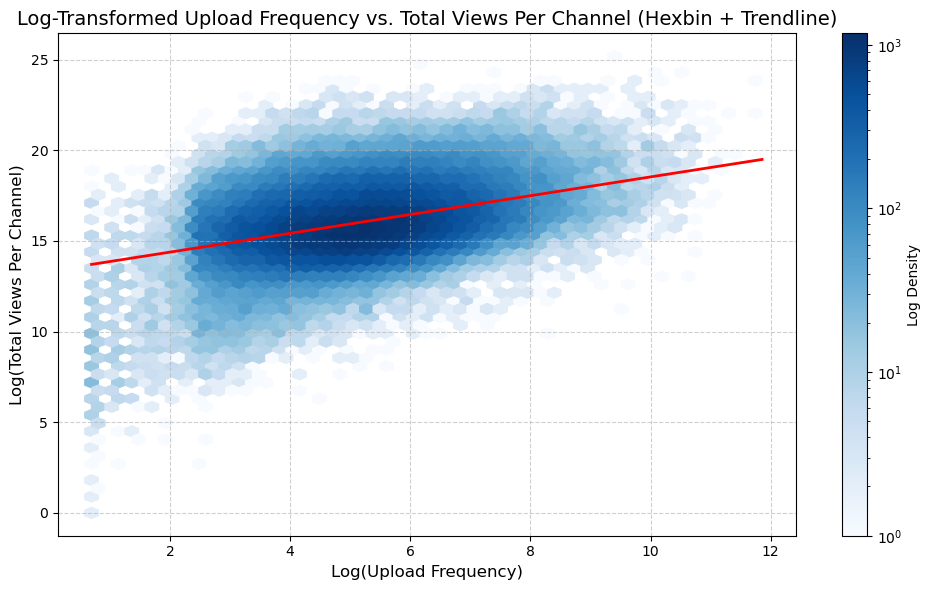

In [37]:
# Log-transform upload frequency and view count
channel_engagement['log_upload_frequency'] = np.log1p(channel_engagement['upload_frequency'])
channel_engagement['log_view_count'] = np.log1p(channel_engagement['total_views_per_channel'])

plt.figure(figsize=(10, 6))
plt.hexbin(
    x=channel_engagement['log_upload_frequency'], 
    y=channel_engagement['log_view_count'], 
    gridsize=50, 
    cmap='Blues', 
    bins='log'
)

sns.regplot(
    x='log_upload_frequency',
    y='log_view_count',
    data=channel_engagement,
    scatter=False,
    color='red',
    line_kws={"lw": 2}
)

plt.colorbar(label='Log Density')
plt.title("Log-Transformed Upload Frequency vs. Total Views Per Channel (Hexbin + Trendline)", fontsize=14)
plt.xlabel("Log(Upload Frequency)", fontsize=12)
plt.ylabel("Log(Total Views Per Channel)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

The red trendline indicates a positive relationship between the log-transformed upload frequency and log-transformed total views per channel. Channels that upload more frequently tend to accumulate more total views, suggesting that higher activity can lead to greater visibility and engagement over time.

The relationship is not perfectly linear (as indicated by the spread), meaning other factors, such as video quality or channel size, also influence total views.

The dark blue hexagons show that the majority of channels fall within the lower range of upload frequency (log ~2–6) and total views (log ~10–15). Most channels upload infrequently but still achieve moderate total views, possibly reflecting part-time or casual content creators.

As the upload frequency increases (log > 6), the density decreases, but total views tend to remain high. This could indicate that only a small proportion of channels maintain a high upload frequency, and these channels are often professional creators or part of high-demand categories (e.g., Gaming or News).

In [38]:
correlation_channel = channel_engagement[['upload_frequency', 'total_views_per_channel', 'total_likes_per_channel', 'total_dislikes_per_channel', 'subscribers']].corr()

print("Correlation Matrix:")
correlation_channel.round(2).style.background_gradient(cmap='coolwarm').format("{:.2f}")

Correlation Matrix:


For channels, we see that upload frequency has little correlation with any of the engagement metrics. There are slight positive correlation between upload frequency and views, likes, dislikes and subscribers per channel.

These small correlations might be explained by the diversity between channels. For example, we could have some channels that got very high total views with just a few uploads while other channels got decent total views with a very high amount of uploads.

That is why we will analyse these same engagements metrics but with respect to the category of the channels. Moreover, later in the notebook, we will analyse the distribution of the upload frequency of channels to see if most views from a category come from a handful number of channels in this same category.

##### Categories Engagement

We analyse in this part if engagement metrics with respect to categories have some correlation with upload frequency.

In [39]:
# Deduplicate the channel-level data to avoid double-counting subscribers and videos
unique_channel_data = channel_video_data[['channel_id', 'channel_category', 'subscribers_cc']].drop_duplicates(subset='channel_id')

# Aggregate engagement metrics and additional data per category
category_engagement = channel_video_data.groupby('channel_category').agg({
    'upload_date': 'count',        # Total uploads per category
    'view_count': 'sum',           # Total views per category
    'like_count': 'sum',           # Total likes per category
    'dislike_count': 'sum'         # Total dislikes per category
}).reset_index()

# Aggregate unique channel-level metrics (subscribers, videos) per category
unique_channel_aggregation = unique_channel_data.groupby('channel_category').agg({
    'subscribers_cc': 'sum',        # Total unique subscribers per category
}).reset_index()

# Merge the two aggregations
category_engagement = pd.merge(category_engagement, unique_channel_aggregation, on='channel_category')

# Rename columns for clarity
category_engagement.rename(columns={
    'upload_date': 'total_uploads',
    'view_count': 'total_views',
    'like_count': 'total_likes',
    'dislike_count': 'total_dislikes',
    'subscribers_cc': 'total_subscribers',
}, inplace=True)

print(category_engagement)

         channel_category  total_uploads   total_views   total_likes  \
0        Autos & Vehicles        2243805  1.182867e+11  9.449940e+08   
1                  Comedy        1020013  3.266239e+11  5.901085e+09   
2               Education        3824752  4.807396e+11  3.028110e+09   
3           Entertainment       12395353  2.310885e+12  2.114761e+10   
4      Film and Animation        1981070  5.206990e+11  3.374969e+09   
5                  Gaming       14017299  1.068579e+12  1.779855e+10   
6           Howto & Style        3819229  3.982713e+11  5.623876e+09   
7                   Music        8420691  2.476947e+12  1.914191e+10   
8         News & Politics        9165234  1.690045e+11  2.049961e+09   
9   Nonprofits & Activism         745835  1.943457e+10  2.367161e+08   
10         People & Blogs        5395696  5.144447e+11  8.370012e+09   
11         Pets & Animals         586236  6.784351e+10  6.212901e+08   
12   Science & Technology        2403432  1.723169e+11  1.937676

In [40]:
print(category_engagement['total_subscribers'].describe())

count    1.500000e+01
mean     2.237845e+09
std      2.448694e+09
min      9.154892e+07
25%      5.391141e+08
50%      1.560583e+09
75%      2.812357e+09
max      8.030449e+09
Name: total_subscribers, dtype: float64


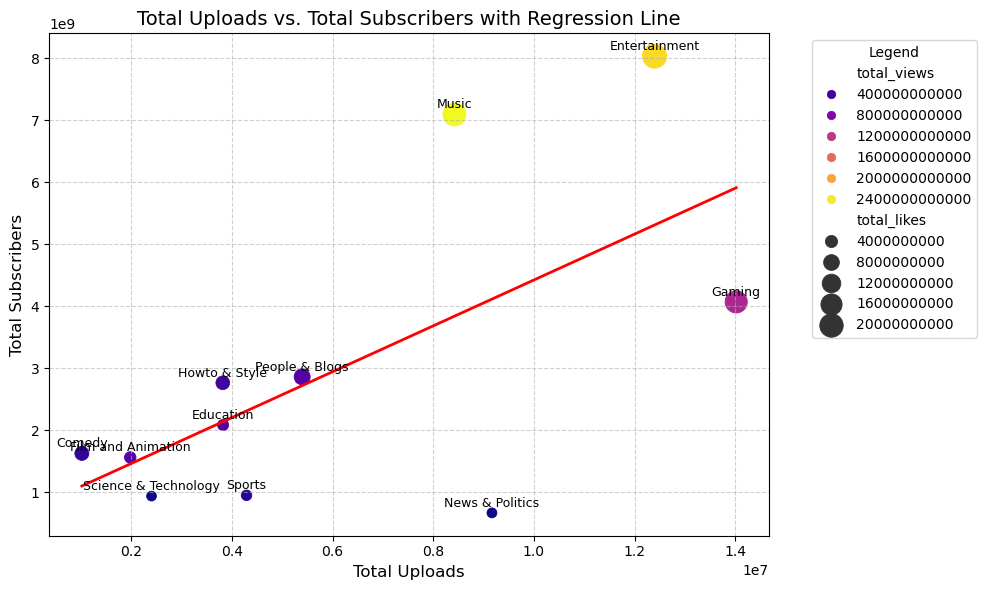

In [41]:
# Set the threshold to the 25th percentile to remove from the plots the categories with
# fewer subscribers that overlap too much for readability in the scatter plot
threshold = 5.39e8  # 539 million subscribers
filtered_category_engagement = category_engagement[category_engagement['total_subscribers'] > threshold]

# Scatter plot for Total Uploads vs. Total Subscribers (filtered) with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='total_uploads', 
    y='total_subscribers', 
    data=filtered_category_engagement, 
    size='total_likes', 
    hue='total_views', 
    palette='plasma', 
    sizes=(50, 300),
    edgecolor=None
)

# Add the regression line
sns.regplot(
    x='total_uploads', 
    y='total_subscribers', 
    data=filtered_category_engagement, 
    scatter=False,
    color='red', 
    line_kws={'lw': 2},
    ci=None
)

# Add category labels just above the bubbles
for i in range(len(filtered_category_engagement)):
    plt.text(
        x=filtered_category_engagement['total_uploads'].iloc[i],
        y=filtered_category_engagement['total_subscribers'].iloc[i] + 0.05e9,
        s=filtered_category_engagement['channel_category'].iloc[i],
        fontsize=9,
        ha='center',
        va='bottom',
        color='black',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none')
    )

# Customize the plot
plt.title("Total Uploads vs. Total Subscribers with Regression Line", fontsize=14)
plt.xlabel("Total Uploads", fontsize=12)
plt.ylabel("Total Subscribers", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), title="Legend")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The red regression line shows a positive trend: as the total uploads increase, the total number of subscribers also tends to increase.

Categories with higher upload activity often have larger subscriber bases, likely because frequent uploads keep the audience engaged and attract more subscribers over time. However, the spread around the regression line suggests variability, meaning upload frequency alone does not fully determine subscriber count.

In [42]:
correlation_category = category_engagement[['total_uploads', 'total_views', 'total_likes', 'total_dislikes', 'total_subscribers']].corr()

print("Correlation Matrix:")
correlation_category.style.background_gradient(cmap='coolwarm').format("{:.2f}")

Correlation Matrix:


The upload frequency at the category-level is highly correlated with engagement metrics (0.70 for the views, 0.82 for the likes, 0.79 for the dislikes and 0.74 for the subscribers).

These correlations are higher at the category-level compared to the channel-level. This might indicate that the variability in upload frequency or engagement metrics between individual channels within a category averages out when aggregated.

That is why, it seems more interesting to analyse the frequency and consistency at the category-level to have a broader view and 'cancel' out disparities and variability between channels.

#### Long-Tail Analysis

We will analyse whether the majority of uploads and views in categories come from a few dominant channels or if the distribution is more uniform.

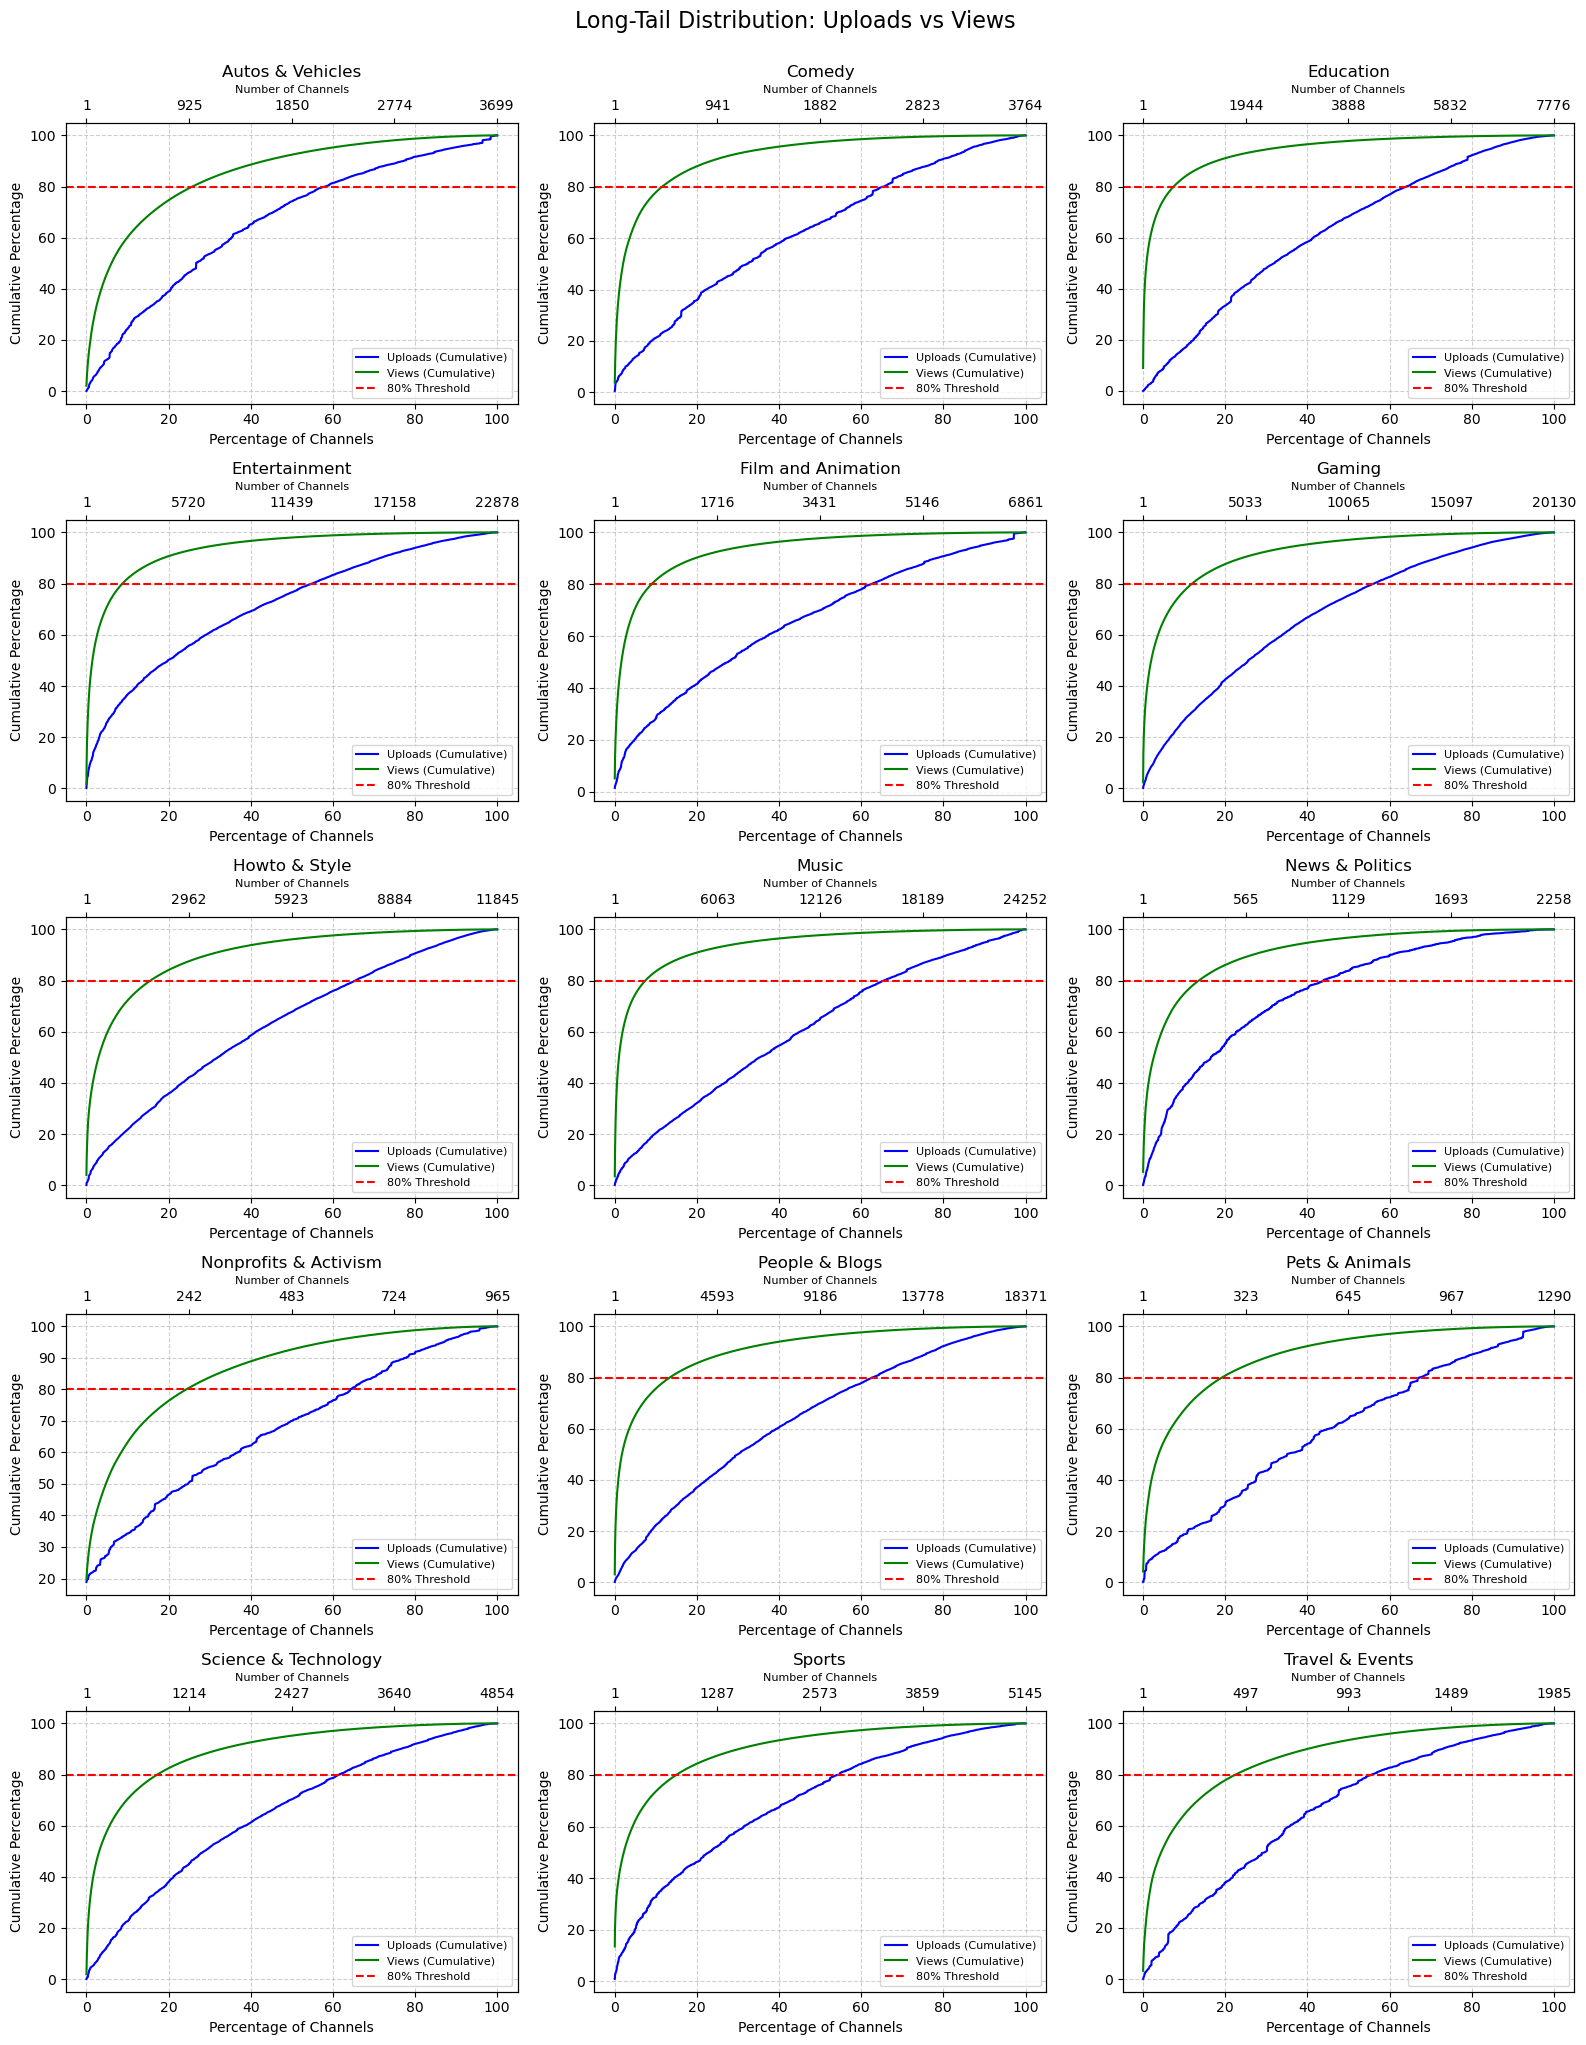

In [43]:
# Aggregate data per channel
channel_contribution = channel_video_data.groupby(['channel_category', 'channel_id']).agg({
    'upload_date': 'count',    # Total uploads per channel
    'view_count': 'sum'        # Total views per channel
}).reset_index()

channel_contribution.rename(columns={
    'upload_date': 'total_uploads',
    'view_count': 'total_views'
}, inplace=True)

# Normalize within each category
channel_contribution['upload_percentage'] = channel_contribution.groupby('channel_category')['total_uploads'].transform(lambda x: x / x.sum() * 100)
channel_contribution['view_percentage'] = channel_contribution.groupby('channel_category')['total_views'].transform(lambda x: x / x.sum() * 100)

categories = channel_contribution['channel_category'].unique()

n_cols = 3
n_rows = int(np.ceil(len(categories) / n_cols))

# Create a figure with subplots
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(16, n_rows * 4),
    sharex=False,
    sharey=False
)

axes = axes.flatten()

for i, category in enumerate(categories):
    # Filter and sort the subset
    subset = channel_contribution[channel_contribution['channel_category'] == category]
    subset = subset.sort_values(by='view_percentage', ascending=False).reset_index()

    # Calculate cumulative percentages
    cumulative_uploads = subset['upload_percentage'].cumsum()
    cumulative_views = subset['view_percentage'].cumsum()
    
    # Calculate x-axis values
    x_percentage = np.linspace(0, 100, len(subset))  # Percentage of channels
    x_channels = np.arange(1, len(subset) + 1)       # Absolute number of channels

    # Get the subplot axis
    ax = axes[i]

    # Plot uploads and views
    ax.plot(x_percentage, cumulative_uploads, label='Uploads (Cumulative)', color='blue')
    ax.plot(x_percentage, cumulative_views, label='Views (Cumulative)', color='green')
    
    # Add secondary x-axis for the number of channels
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())  # Match x-axis limits
    ax2.set_xticks(np.linspace(0, 100, 5))  # Match percentage scale for better alignment
    ax2.set_xticklabels(np.linspace(1, len(subset), 5, dtype=int))  # Actual channel numbers
    
    # Customize secondary x-axis
    ax2.set_xlabel("Number of Channels", fontsize=8)

    # Add titles and labels
    ax.set_title(f"{category}", fontsize=12)
    ax.set_xlabel("Percentage of Channels", fontsize=10)
    ax.set_ylabel("Cumulative Percentage", fontsize=10)
    ax.axhline(80, color='red', linestyle='--', label="80% Threshold")
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide unused subplots (if categories are fewer than the grid)
for j in range(len(categories), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Long-Tail Distribution: Uploads vs Views", fontsize=16, y=1.02)
plt.show()

In the plots above, we sorted the channels in descending order with respect to the number of views (i.e. the first channels in the x-axis are the channels with the most views).

As we can see from the plots, we attain for almost every categories 80 % of the total views of the category with less than 20 % of the channels in this category. This means that a small amount of channels have an extremely high number of views that contribute to the success of their respective categories.

Whereas, the uploads cumulative curve being more gradual indicates that the channels that have the biggest impact on views are not necessarily the channels that have the highest upload frequency.

## Consistency Analysis

Consistency measures the regularity of video uploads within a channel category over a specific time period. It reflects how evenly spaced or predictable the uploads are across time, providing insight into the stability of content creation behavior.

High consistency indicates uploads occur at regular intervals. Low consistency indicates irregular or sporadic uploads.

Channels that upload consistently are often more professional, as they follow a predictable schedule. High consistency often correlates with better audience retention and channel growth.

Consistency will be measured as the standard deviation of upload frequency and in variation of active periods, for example what is the average time period between two uploaded videos in a certain category ?

In [44]:
category_monthly_data = channel_video_data.groupby(['channel_category', 'channel_id', 'upload_date']).agg({
    'view_count': 'sum',  # Total views per time period
    'upload_date': 'count'  # Total uploads per time period
}).rename(columns={'upload_date': 'uploads'}).reset_index()

# Add a 'year_month' column for monthly aggregation
category_monthly_data['year_month'] = category_monthly_data['upload_date'].dt.to_period('M')

print(category_monthly_data.head())

   channel_category                channel_id upload_date  view_count  \
0  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw  2017-01-21       900.0   
1  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw  2017-02-03      2393.0   
2  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw  2017-02-12       456.0   
3  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw  2017-02-19       749.0   
4  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw  2017-02-23       914.0   

   uploads year_month  
0        1    2017-01  
1        1    2017-02  
2        1    2017-02  
3        1    2017-02  
4        1    2017-02  


In [45]:
# Calculate consistency metrics per channel
channel_metrics = category_monthly_data.groupby(['channel_category', 'channel_id']).agg({
    'uploads': ['sum', 'mean', 'std'],  # Total, mean, and standard deviation of uploads
    'view_count': ['sum', 'mean', 'std']  # Total, mean, and standard deviation of views
}).reset_index()

# Flatten the column names
channel_metrics.columns = ['channel_category', 'channel_id', 'total_uploads', 'avg_uploads', 'std_uploads', 
                           'total_views', 'avg_views', 'std_views']

print(channel_metrics.head())

   channel_category                channel_id  total_uploads  avg_uploads  \
0  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw             52     1.000000   
1  Autos & Vehicles  UC-1CvlOVGAUzvffUyLOQ0hA            137     1.191304   
2  Autos & Vehicles  UC-1PkmLrFt6apyXAnB0LbNw            304     1.048276   
3  Autos & Vehicles  UC-1W6GKASWrqZfK45zFLapg            202     1.020202   
4  Autos & Vehicles  UC-31-rclcsuDPqfwh-rENuw             49     1.000000   

   std_uploads  total_views     avg_views      std_views  
0     0.000000    3458632.0  66512.153846  416692.469833  
1     0.748046    1532540.0  13326.434783   20142.921714  
2     0.230271   22064189.0  76083.410345  474461.473885  
3     0.224391    9576806.0  48367.707071  153731.365137  
4     0.000000    3149696.0  64279.510204  263573.820605  


In [46]:
# Count active months with at least 2 uploads per channel
active_months = category_monthly_data[category_monthly_data['uploads'] >= 2].groupby(['channel_category', 'channel_id'])['year_month'].nunique()

# Merge active months into channel_metrics
channel_metrics = channel_metrics.merge(active_months.rename('active_months'), on=['channel_category', 'channel_id'], how='left')

# Fill missing active_months with 0 (channels that never had an active month)
channel_metrics['active_months'] = channel_metrics['active_months'].fillna(0)

# Calculate proportion of active months
total_months = category_monthly_data['year_month'].nunique()  # Total number of unique months
channel_metrics['proportion_active'] = channel_metrics['active_months'] / total_months

print(channel_metrics.head())

   channel_category                channel_id  total_uploads  avg_uploads  \
0  Autos & Vehicles  UC--aOG_a2afAna8t3xvRkuw             52     1.000000   
1  Autos & Vehicles  UC-1CvlOVGAUzvffUyLOQ0hA            137     1.191304   
2  Autos & Vehicles  UC-1PkmLrFt6apyXAnB0LbNw            304     1.048276   
3  Autos & Vehicles  UC-1W6GKASWrqZfK45zFLapg            202     1.020202   
4  Autos & Vehicles  UC-31-rclcsuDPqfwh-rENuw             49     1.000000   

   std_uploads  total_views     avg_views      std_views  active_months  \
0     0.000000    3458632.0  66512.153846  416692.469833            0.0   
1     0.748046    1532540.0  13326.434783   20142.921714            8.0   
2     0.230271   22064189.0  76083.410345  474461.473885            8.0   
3     0.224391    9576806.0  48367.707071  153731.365137            1.0   
4     0.000000    3149696.0  64279.510204  263573.820605            0.0   

   proportion_active  
0           0.000000  
1           0.045977  
2           0.045

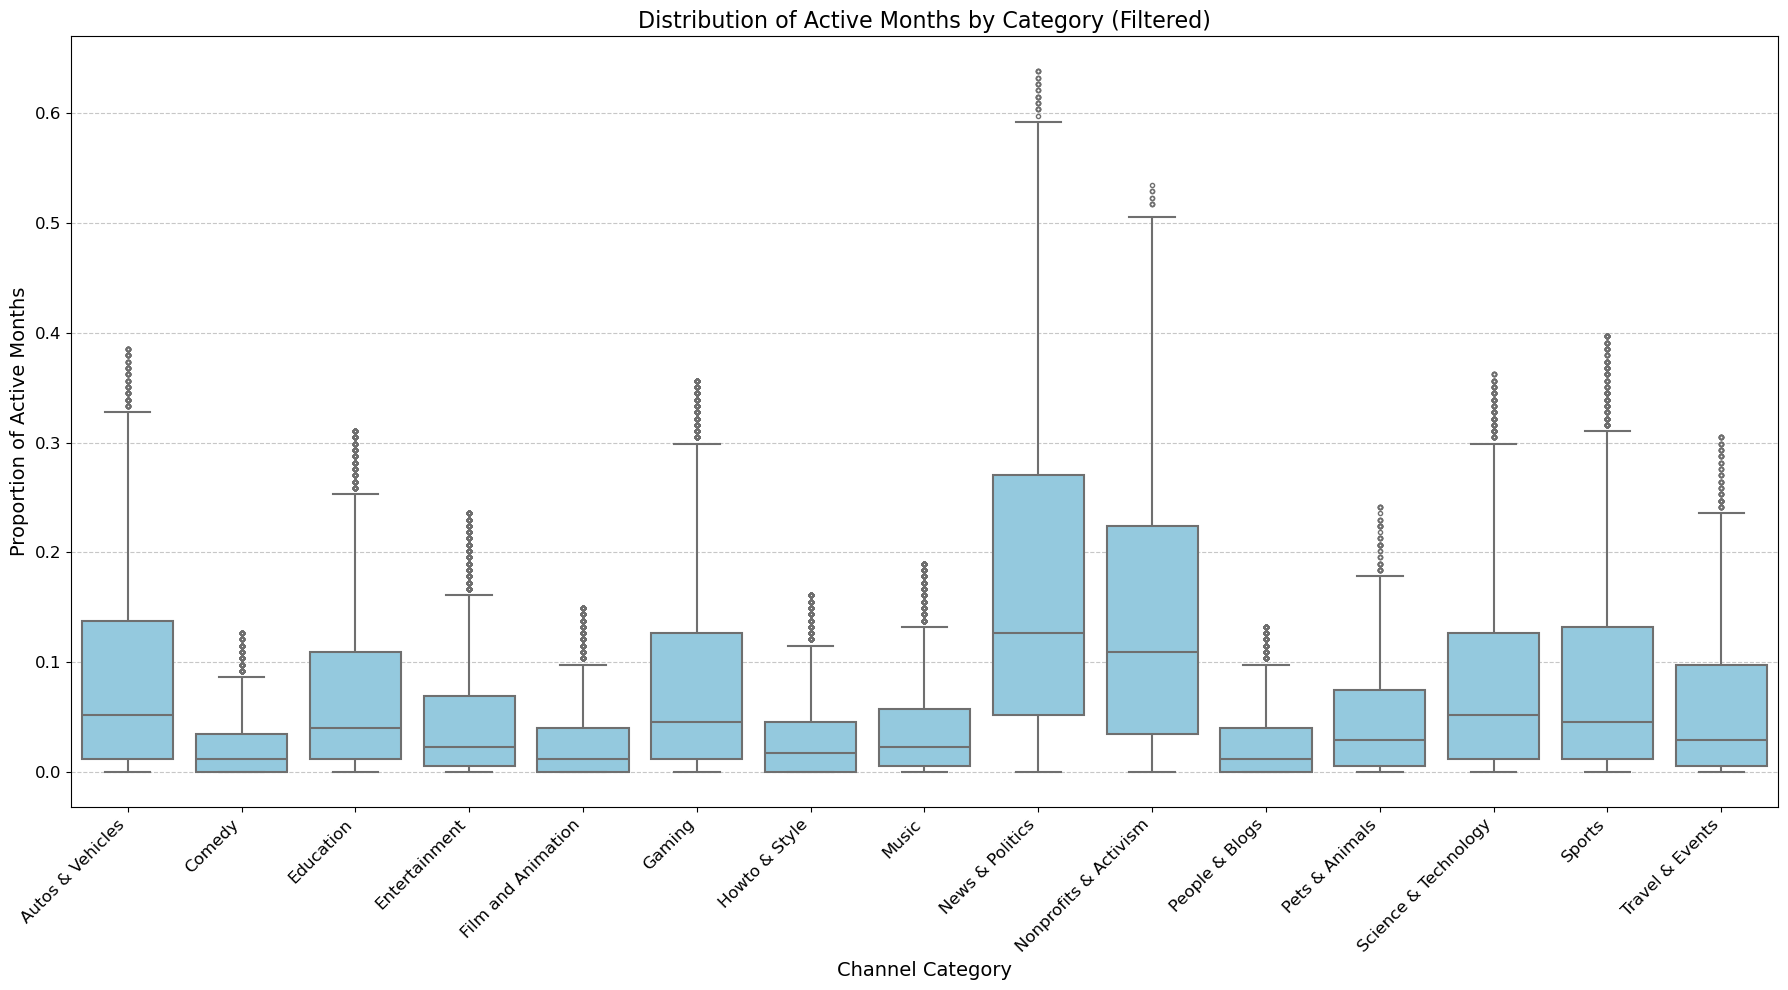

In [47]:
# Calculate IQR for each category
Q1 = channel_metrics.groupby('channel_category')['proportion_active'].quantile(0.25)
Q3 = channel_metrics.groupby('channel_category')['proportion_active'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
lower_bound = (Q1 - 1.5 * IQR).reindex(channel_metrics['channel_category'])
upper_bound = (Q3 + 1.5 * IQR).reindex(channel_metrics['channel_category'])

# Filter out outliers
filtered_channel_metrics = channel_metrics[
    (channel_metrics['proportion_active'] >= lower_bound.values) &
    (channel_metrics['proportion_active'] <= upper_bound.values)
]


plt.figure(figsize=(18, 10))
sns.boxplot(
    data=filtered_channel_metrics,
    x='channel_category',
    y='proportion_active',
    color='skyblue',
    fliersize=3,
    linewidth=1.5
)


plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Active Months by Category (Filtered)", fontsize=16)
plt.ylabel("Proportion of Active Months", fontsize=14)
plt.xlabel("Channel Category", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

This plot provides an analysis of the proportion of active months for channels in each category, where an active month is defined as a month with at least 2 uploads. The outliers have been filtered out using the Interquartile Range (IQR) rule, ensuring that the focus remains on typical channel behavior within each category.

The box represents the interquartile range (IQR), which contains the middle 50% of the data. The line inside the box represents the median proportion of active months for channels in each category. The whiskers extend to the smallest and largest data points within 1.5 times the IQR from the lower and upper quartiles, respectively.

Categories like News & Politics and Nonprofits & Activism show a much wider distribution (large IQR and whiskers), indicating significant variability in channel consistency within these categories.

Categories such as Comedy and People & Blogs have much narrower distributions, suggesting more uniform activity levels among channels in these categories.

The height of the boxes and length of the whiskers indicate the diversity in the consistency of uploads. Categories with larger boxes and whiskers exhibit greater diversity in channel activity, while smaller boxes and whiskers indicate more homogeneity.

Categories with larger IQRs and higher medians, like News & Politics, likely have more professional channels with consistent uploading schedules.

Categories with smaller IQRs and lower medians, like Comedy, might have less predictable upload schedules or smaller numbers of active channels.

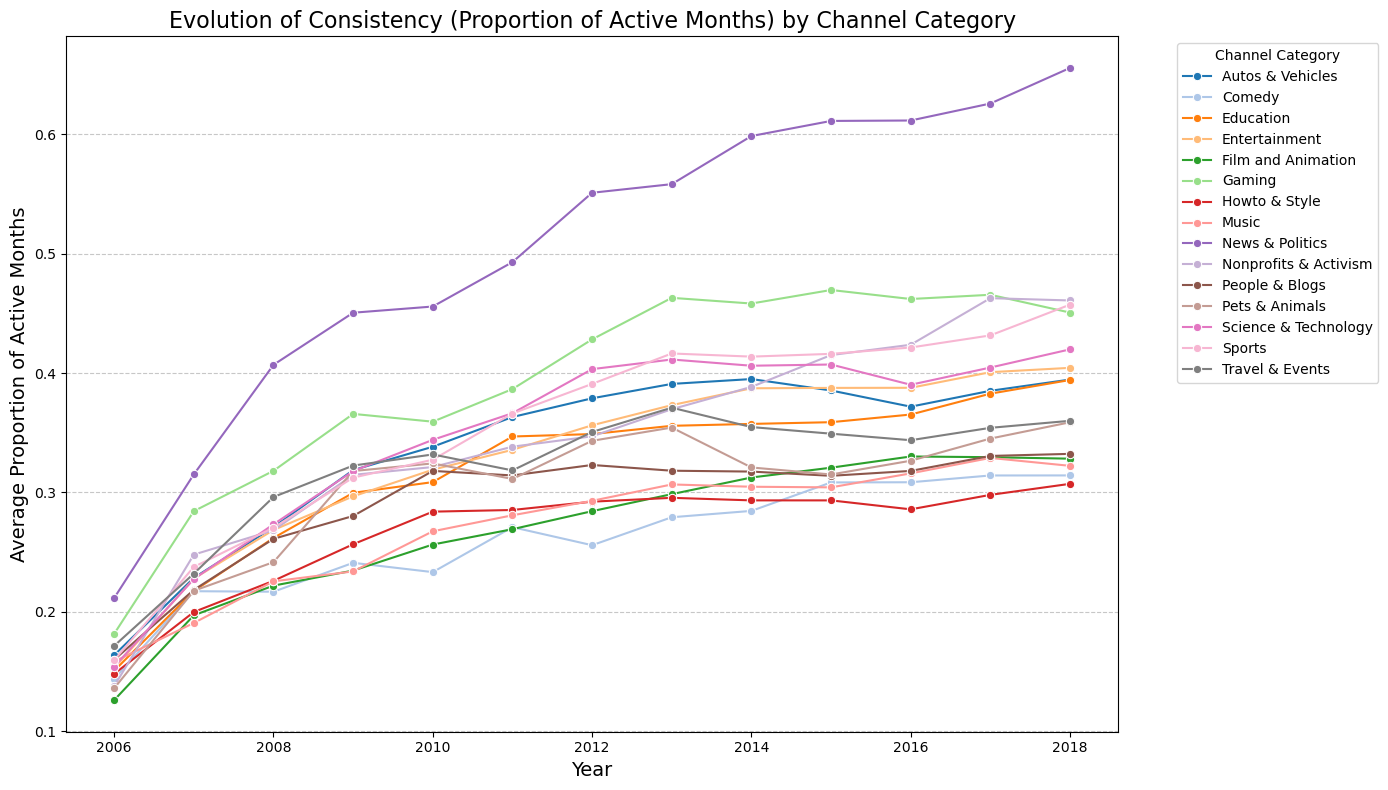

In [48]:
# Add a 'year' column to the dataset
category_monthly_data['year'] = category_monthly_data['year_month'].dt.year

# Calculate active months for each channel per year and category
yearly_active_months = category_monthly_data[category_monthly_data['uploads'] >= 2].groupby(
    ['channel_category', 'channel_id', 'year']
)['year_month'].nunique().reset_index()

yearly_active_months.rename(columns={'year_month': 'active_months'}, inplace=True)

# Calculate yearly average proportion of active months for each category
total_months_per_year = 12
yearly_active_months['proportion_active'] = yearly_active_months['active_months'] / total_months_per_year

# Aggregate by category and year to compute the mean proportion of active months
category_yearly_consistency = yearly_active_months.groupby(['channel_category', 'year'])['proportion_active'].mean().reset_index()

# Filter data to include only years up to 2018 because we don't have data for thw whole year 2019
filtered_consistency_data = category_yearly_consistency[
    (category_yearly_consistency['year'] >= 2006) & 
    (category_yearly_consistency['year'] <= 2018)
]

custom_palette = sns.color_palette("tab20", n_colors=15)

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_consistency_data,
    x='year',
    y='proportion_active',
    hue='channel_category',
    palette=custom_palette,
    marker='o'
)

plt.title("Evolution of Consistency (Proportion of Active Months) by Channel Category", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Proportion of Active Months", fontsize=14)
plt.legend(title="Channel Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

The plot above suggests that the consistency of channels has grown over time. This might indicate that YouTube has evolved as a platform over time and became more professionalized. Obviously the category 'News & Politics' seems to have high consistency due to the nature of its subject (news are time-sensitive and need to be updated all the time).

Creators became more and more consistent in their behavior of content creation over time, suggesting that creators are taking their content creation hobby more seriously and potentially pointing out that it's not about just creating some videos for fun but it's about making new content in a more serious manner maybe indicating a profession.

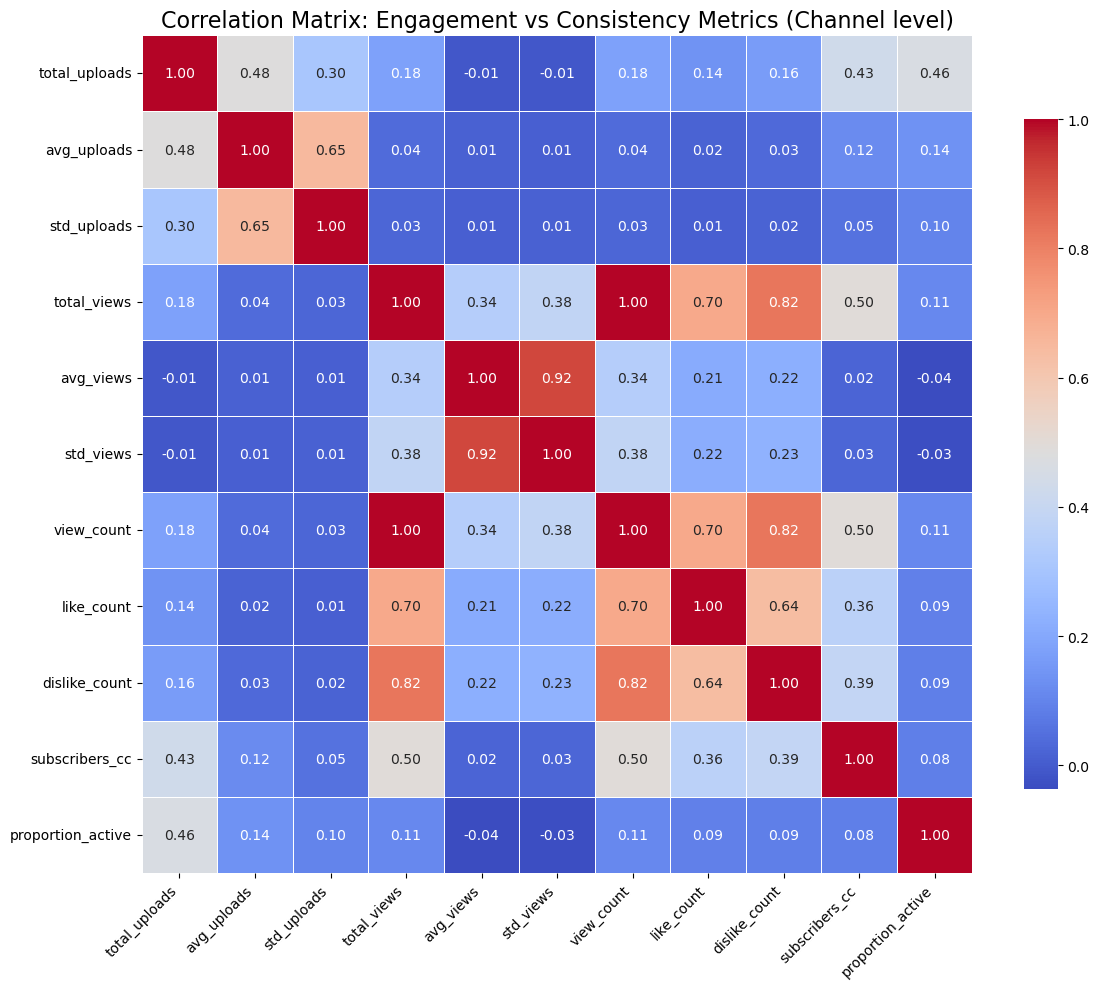

In [49]:
# Aggregate engagement metrics per channel
engagement_metrics = channel_video_data.groupby(['channel_id', 'channel_category']).agg({
    'view_count': 'sum',       # Total views
    'like_count': 'sum',       # Total likes
    'dislike_count': 'sum',    # Total dislikes
    'subscribers_cc': 'sum'    # Total subscribers
}).reset_index()

# Merge engagement metrics with consistency metrics
merged_metrics = pd.merge(
    channel_metrics, 
    engagement_metrics, 
    on=['channel_id', 'channel_category'], 
    how='left'
)

# Select relevant columns for correlation analysis
correlation_data = merged_metrics[[
    'total_uploads', 'avg_uploads', 'std_uploads',    # Upload metrics
    'total_views', 'avg_views', 'std_views',          # View metrics
    'view_count', 'like_count', 'dislike_count',      # Engagement metrics
    'subscribers_cc',                                 # Subscribers
    'proportion_active'                               # Consistency metrics
]]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={'shrink': 0.8}
)

plt.title("Correlation Matrix: Engagement vs Consistency Metrics (Channel level)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

We can see that the consistency of uploads represented by the proportion of active months isn't correlated with any engagement metrics such as likes, dislikes, views and subscribers at the channels-level. This could indicate that the consistency of uploads isn't relevant to the growth of the channel.

But again, these small correlations might be explained by the diversity of the channels just like for the frequency. That is why we will below consider the consistency metrics in the category level to correlate them with engagement metrics.

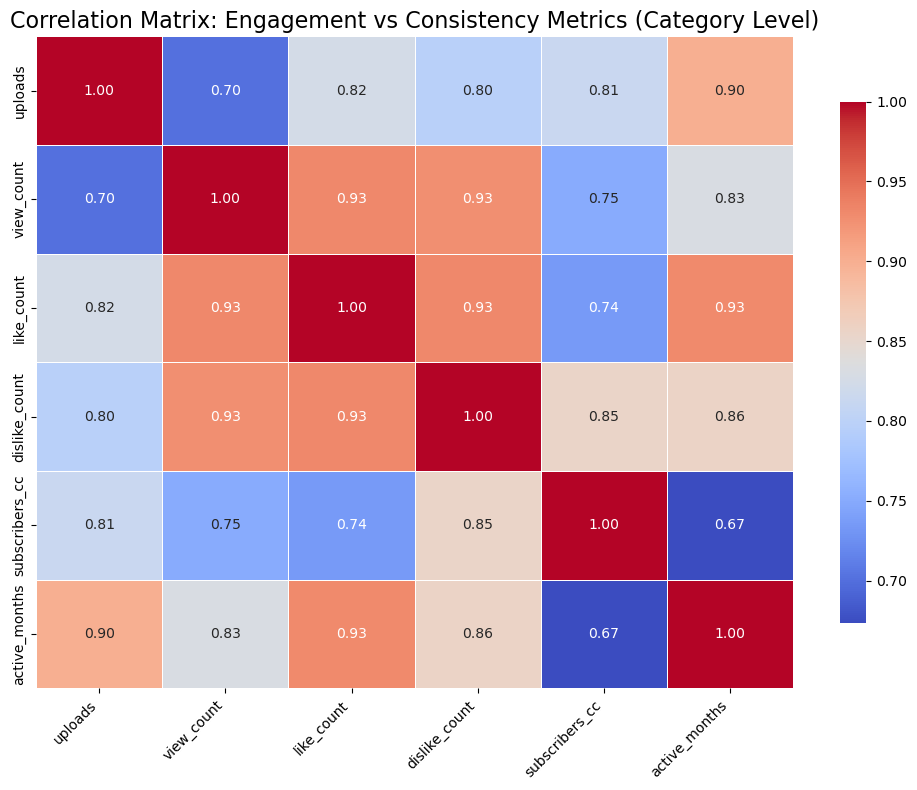

In [50]:
# Aggregate metrics at the category level
category_metrics = channel_video_data.groupby('channel_category').agg({
    'view_count': 'sum',       # Total views
    'like_count': 'sum',       # Total likes
    'dislike_count': 'sum',    # Total dislikes
    'subscribers_cc': 'sum',   # Total subscribers
    'upload_date': 'count'     # Total uploads
}).reset_index()

# Rename the upload_date column to uploads
category_metrics.rename(columns={'upload_date': 'uploads'}, inplace=True)

# Add consistency metrics at the category level
category_consistency = channel_metrics.groupby('channel_category').agg({
    'active_months': 'sum',    # Total active months for the category
}).reset_index()

# Merge category-level engagement and consistency metrics
category_data = pd.merge(
    category_metrics,
    category_consistency,
    on='channel_category',
    how='left'
)

# Select relevant columns for correlation analysis
correlation_data_category = category_data[[
    'uploads',              # Upload metrics
    'view_count', 'like_count', 'dislike_count',  # Engagement metrics
    'subscribers_cc',       # Subscribers
    'active_months'         # Total active months
]]

# Compute the correlation matrix
correlation_matrix_category = correlation_data_category.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_category, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={'shrink': 0.8}
)

plt.title("Correlation Matrix: Engagement vs Consistency Metrics (Category Level)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

The active_months metric in this correlation matrix is a representation of upload consistency for each category, as it measures the total number of months where significant activity occurred.

As we can see with respect to categories, the consistency metric represented by the total number of active months in the dataset is highly correlated with the engagement metrics (0.83 for views, 0.93 for likes, 0.86 for dislikes and 0.67 for subscribers) suggesting that categories that have more consistent uploads (active months) also tend to have higher overall engagement (views, likes, dislikes).

Moreover, active months could be a good indicator of professionalization. Categories with high active months likely represent more professionalized or established creators, as consistent uploads are often a hallmark of serious content creators.

## Conclusion

This notebook analyzed the frequency and consistency of YouTube content creation across categories over time, providing insight into the professionalization of creators on the platform. By examining upload patterns and their correlations with key engagement metrics, we identified trends that highlight the role of consistent content creation in YouTube's evolution.

The time-series analysis revealed a clear upward trajectory in upload frequencies across most categories, particularly post-2010. This growth aligns with YouTube's rise as a professional content platform, supporting creators who treat content creation as a career rather than a hobby.

While this analysis focused on content upload frequency and consistency, it opens pathways for complementary research questions explored by other team members:

- Which categories led YouTube's professionalization, and how did professional practices spread?

- How has creator content strategy evolved to reflect professional monetization approaches?

- How does investment in content production reflect the transition from hobby to profession?

- How has community management evolved from casual interaction to professional engagement strategies?

By combining these analyses, we aim to build a comprehensive understanding of YouTube’s transformation into a platform that empowers digital content creators to pursue full-time careers.

---
---

# RQ2: Which content categories have driven the professionalization of YouTube, and how have professional practices been adopted and disseminated across these categories?

This research investigates the diverse impacts of professionalization across various YouTube video categories, emphasizing that professionalization is not a uniform process but rather a phenomenon that has evolved over time across different types of content on the platform. It was demonstrated in the first part that the behavioral variance of channels within the same category is significant, making it more relevant to analyze professionalization at the category level rather than at the channel level. In this section dedicated to the evolution of professionalization, the analyses are therefore conducted solely at the category level of channels.

The study is structured into three parts:

1. Exploration of Monetization Strategies:
The first section examines how different YouTube channel categories adopt and utilize various monetization strategies.
2. Testing Hypotheses on Monetization Behaviors:
In the second section, hypotheses related to monetization behaviors are tested. This enables a comprehensive evaluation of how professional practices have evolved over time.
3. Mapping Correlations Through Bubble Plot Analysis:
The final section presents a bubble plot analysis to visualize the correlations between findings from the first two sections. A critical hypothesis is proposed

## Importing Pretreated Datasets

**To get started:** \
\
Required datasets from YouNiverse or Panada's Github repository: 
- yt_metadata_en.jsonl.gz 
- youtube_monetization_api.csv
- df_channels_en.tsv.gz

Python files to run:
1. generate_df_channel_monetization.py --> 'datasets/clean_channel_monetization.csv'
2. generate_clean_professionalization_in_description.py --> 'datasets/clean_professionalization_in_description.csv'
3. generate_clean_df_cross_analysis.py --> 'datasets/df_cross_analysis.csv' & 'datasets/size.csv'

\
/!\ Caution /!\ \
Chunks are set to 20'000 in 2. and 3., but should be lowered depending on the RAM and availability
- For 8GB RAM: chunk_size around 10,000-20,000 rows
- For 16GB RAM: chunk_size around 20,000-40,000 rows
- For 32GB RAM: chunk_size around 40,000-80,000 rows

In [6]:
data_path = 'datasets'
Color_norm = 'haline'
clean_channel_monetization = pd.read_csv( os.path.join(data_path, "clean_channel_monetization.csv"),sep=",")
df_analysis = pd.read_csv(os.path.join(data_path, "clean_professionalization_in_description.csv"),sep=",")
df_cross =  pd.read_csv(os.path.join(data_path, "df_cross_analysis.csv"),sep=",")
df_sizes =  pd.read_csv(os.path.join(data_path, "sizes.csv"),sep=",")

## Data Visualization and Analysis

### RQ2.1 - Monetization strategies across channel categories

In this first section, we analyze a representative sample of YouTube channels to examine their use of the monetization methods provided by YouTube and listed in the YouTube API. This sample accounts for approximately 25% of the YouNiverse database, with category proportions closely mirroring those of the entire dataset.
By leveraging this information, we can accurately quantify the adoption of various monetization methods across different channel categories.

The analysis begins by presenting the distribution of each category within the dataset. Subsequently, we explore how each video category contributes to the usage of different monetization methods. Finally, frequency histograms illustrating the utilization patterns of these methods are presented for deeper insights.

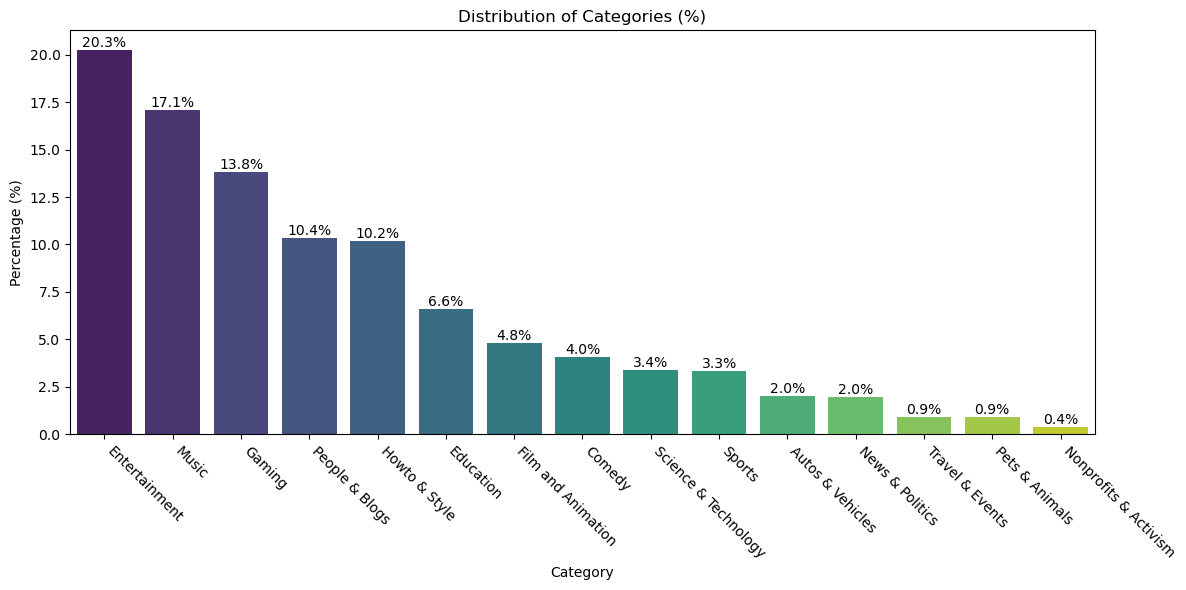

In [18]:
color_map, colors = create_color_mapping(clean_channel_monetization)
fig1 = plot_category_distribution(clean_channel_monetization, color_map)

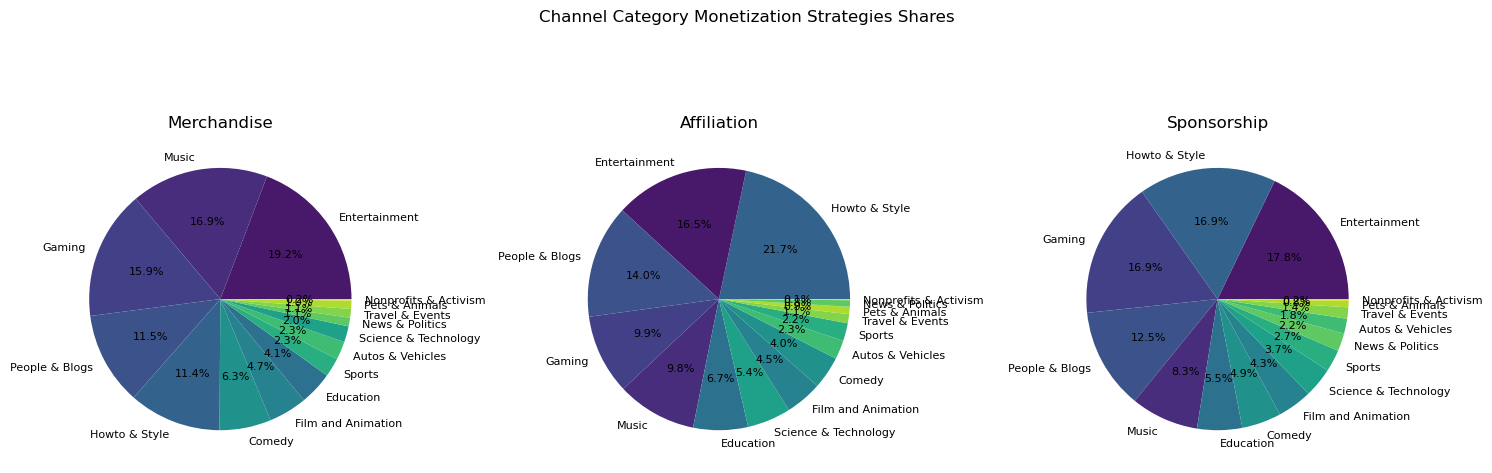

In [19]:
fig2 = plot_monetization_shares(clean_channel_monetization, 
                                ['has_merchandise', 'has_affiliate', 'has_sponsorships'], 
                                color_map)

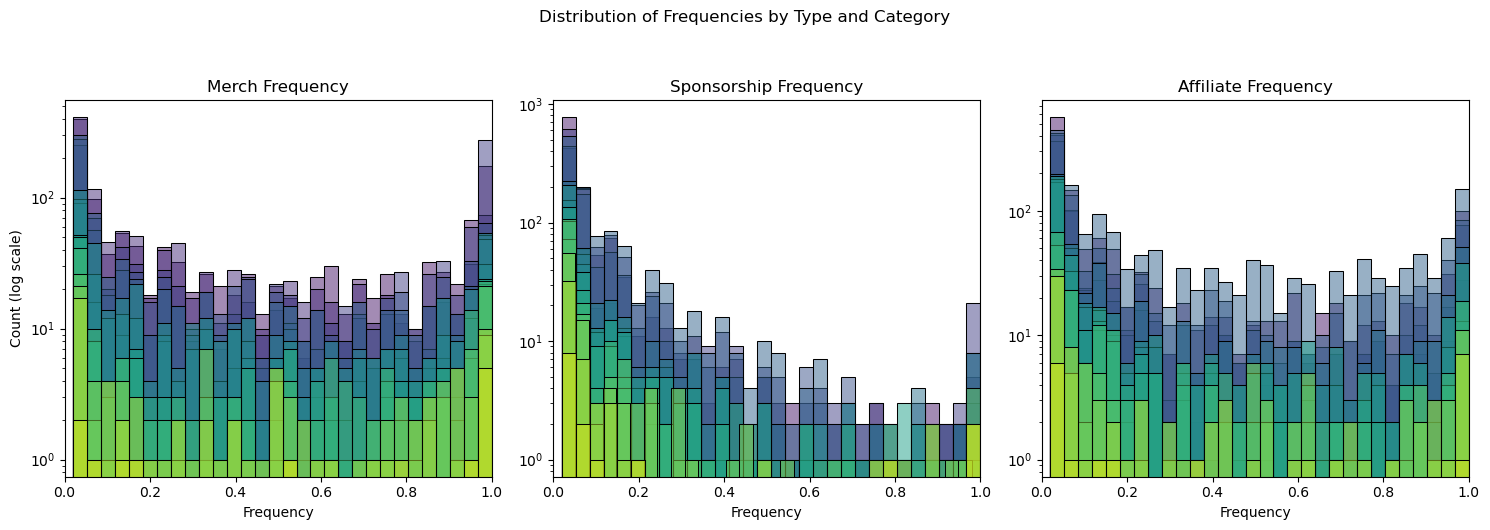

In [20]:
fig3 = plot_stacked_distributions(clean_channel_monetization, color_map)

As seen in the previous section, certain categories hold a dominant position on YouTube. However, while previous metrics may have highlighted categories like News & Politics as strong due to higher activity across a larger proportion of channels in this category, the small number of channels in the dataset prevents it from having a prominent place in the following analysis.

When analyzing the data through the number of videos and channels grouped by category, the findings shift focus from the average individual channel engagement to broader global phenomena impacting specific categories. In this context, Entertainment, Music, Gaming, and People & Blogs (in that order) emerge as the categories with the most content in the dataset.

Looking at the share of each category in the use of monetization methods — such as affiliation, merchandise, or sponsorship — this ranking remains relatively consistent. However, two notable trends emerge:

The How-To & Style category shows a significantly higher use of affiliation and sponsorship than other categories, despite being only the 5th largest category in terms of content. This suggests external monetization methods are more prevalent in this category.
Regarding the frequency of external monetization methods — defined as the proportion of videos on a given channel using these strategies, grouped by category — most channels exhibit low frequencies of use. This is followed by a decline and then a spike at the highest usage frequencies.
This trend indicates that even when grouping by category, a small number of dominant channels make intense use of external monetization methods, while a much larger number of channels use these strategies inconsistently.

Note: Movies and Shows are not present in this dataset. In the third part, they are very minor, even in the youniverse dataset (10^0 order of magnitude against 10^5 for the rest). This remark also stands for Film and Animations. 

### RQ2.2 - Monetization and Professionalization-related behaviors through time

Although hyperlinks may be due to copyright issues, they also reflect either a diversification of the content creator’s activities, who uses this channel to promote them, or links to affiliate partners that help them supplement their income. Therefore, the presence of hyperlinks appears to be a relevant marker of professionalization.
In addition, certain words frequently appear in video descriptions, and apart from a few exceptions or misunderstandings, they are often associated with commercial activities or merchandise. In this section, the focus will be on three specific words: "shop," "support," and "ad."

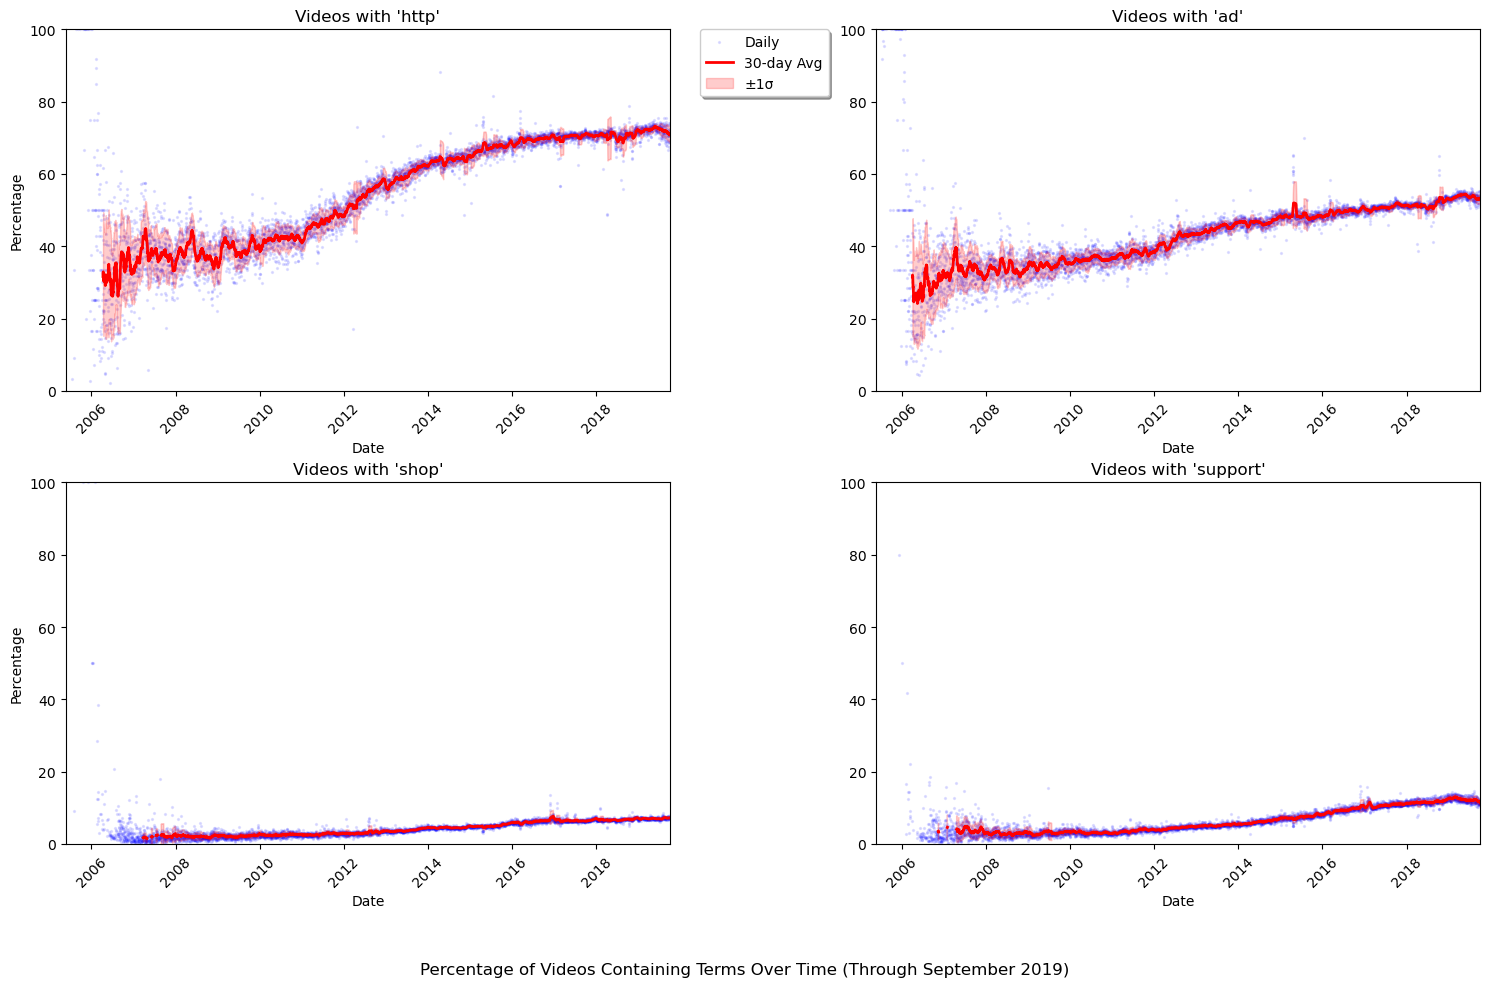

In [24]:
fig4 = plot_time_series_grid(df_analysis)
plt.show()

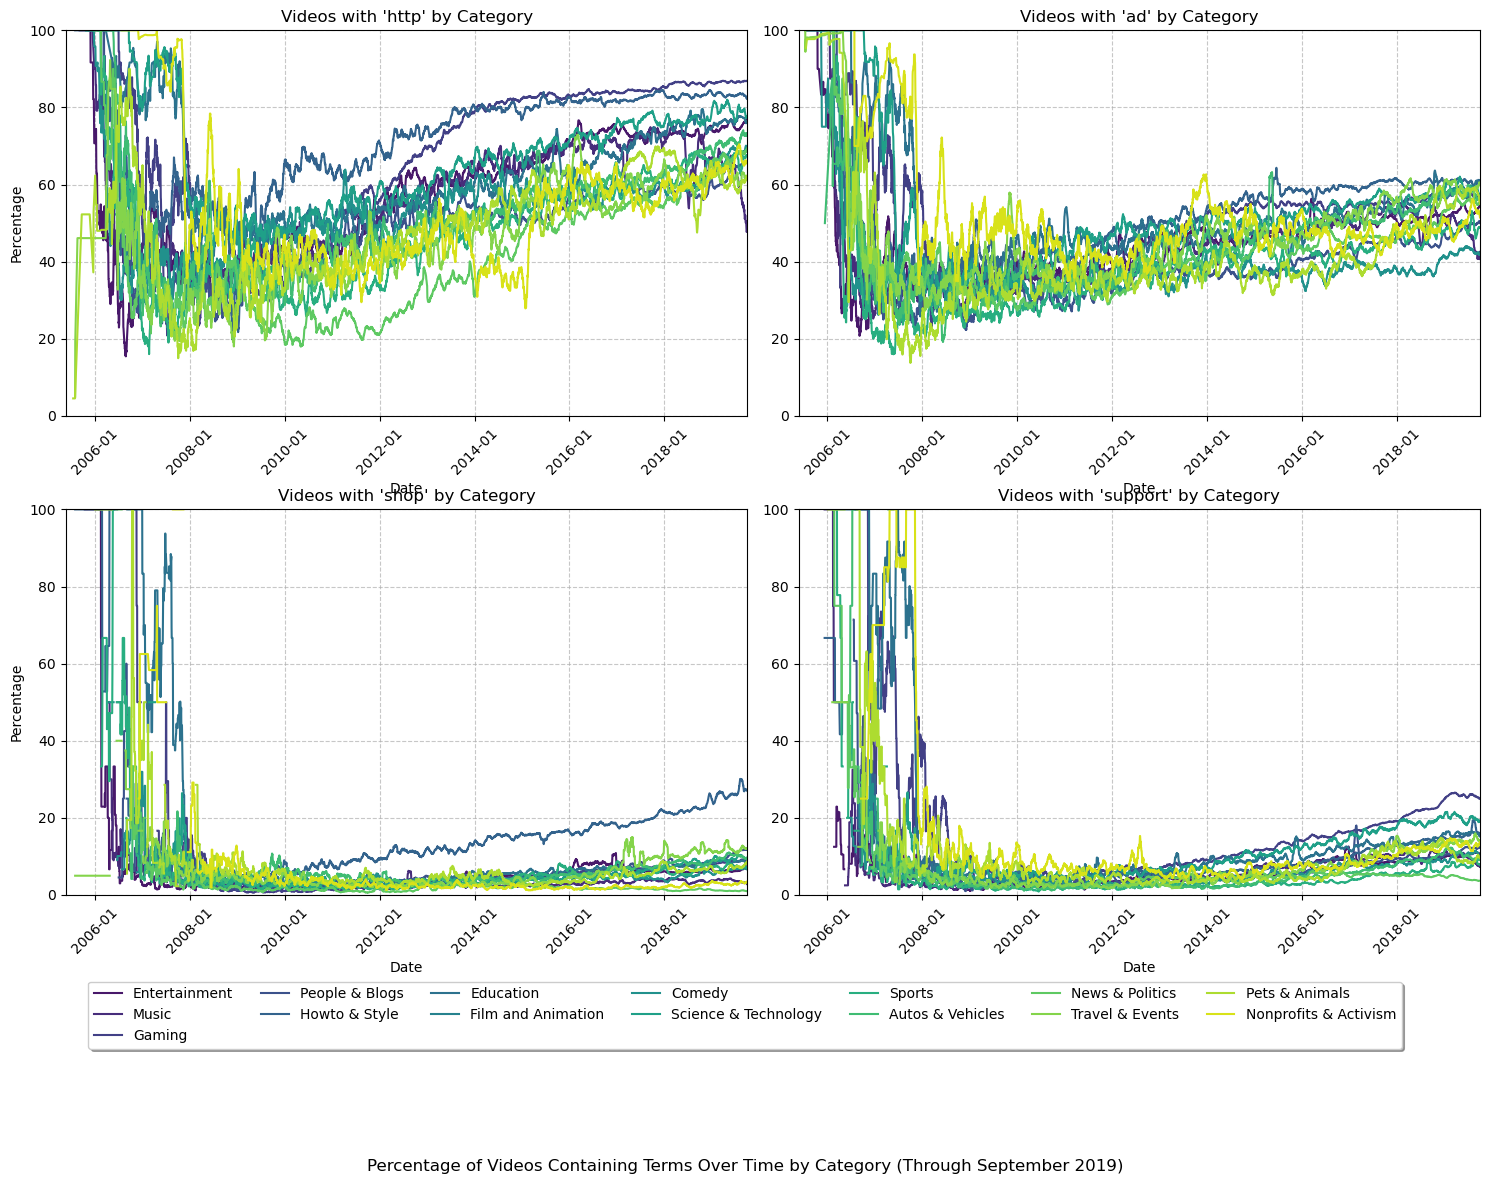

In [25]:
fig5 = plot_time_series_grid_cat(df_analysis, color_map=color_map)
plt.show()

From these plots, we can observe that the use of terms in video descriptions related to professionalization and/or external revenue generation has increased proportionally over the years. However, this growth is not equally intense for all terms. 

On one hand, terms strongly associated with external income, such as **"shop"** or **"support"**, show a steady increase of +8% and +6%, respectively, between 2008 and 2019, with relatively linear growth. On the other hand, for more ambiguous terms like the presence of **internet links** or the term **"ad"**, the growth is much more pronounced: +30% and +18%, respectively. For links, there is a noticeable surge between 2010 and 2015, whereas the growth of "ad" is more linear but with a steeper slope overall.

Based on this analysis, we can hypothesize that over time, YouTubers increasingly utilized the description space of their videos as a communication channel with viewers. This space has become a key tool for inviting financial participation in the channel's development. For example, the term **"support"** often refers to crowdfunding, while **"shop"** frequently points to links that generate revenue for the creator. 

Although it's not possible to delve into every specific use case, it is clear that the exploitation of video descriptions has become a significant driver of professionalization over time.

### RQ2.3 - Cross-Analysis of Monetization Usage and Professionalization Behaviors Across Channel Categories

To address the initial question more fully, it seems worthwhile to explore whether the actual use of monetization within a category and the utilization of the description space are correlated. The following charts illustrate, for each category, the total number of videos containing one of the monetization-related terms in their description, plotted against the total number of videos using merchandise, affiliation, or sponsorship. A log-log representation is used due to the large volume of data, and the size of each data point reflects the weight of the respective category.

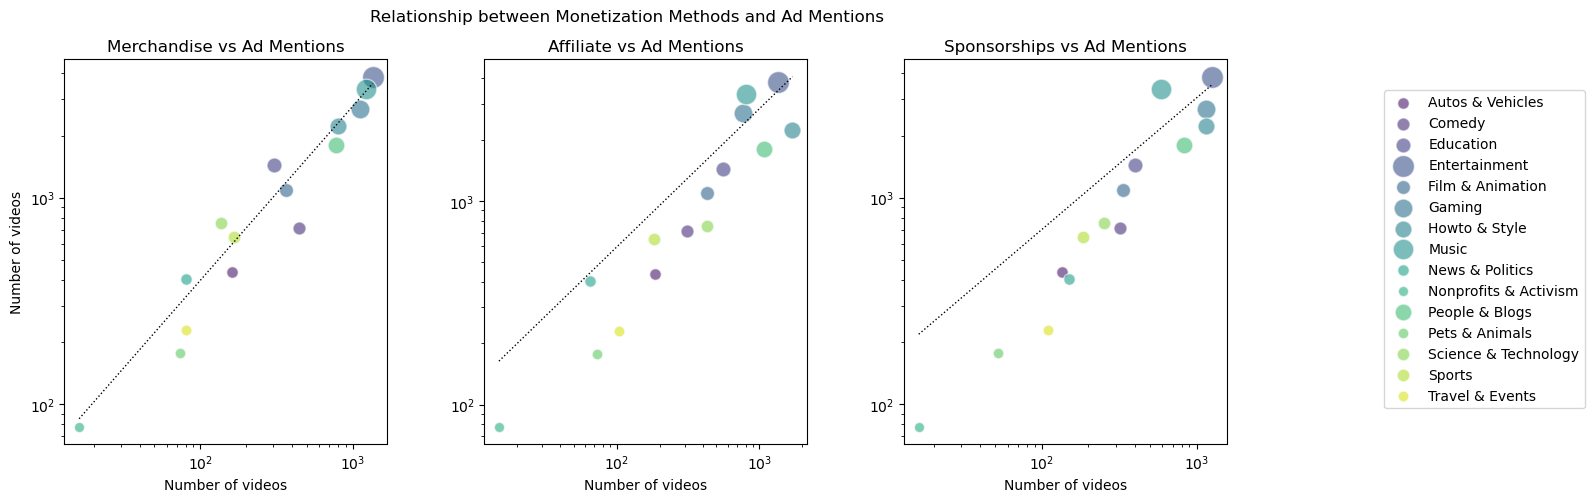

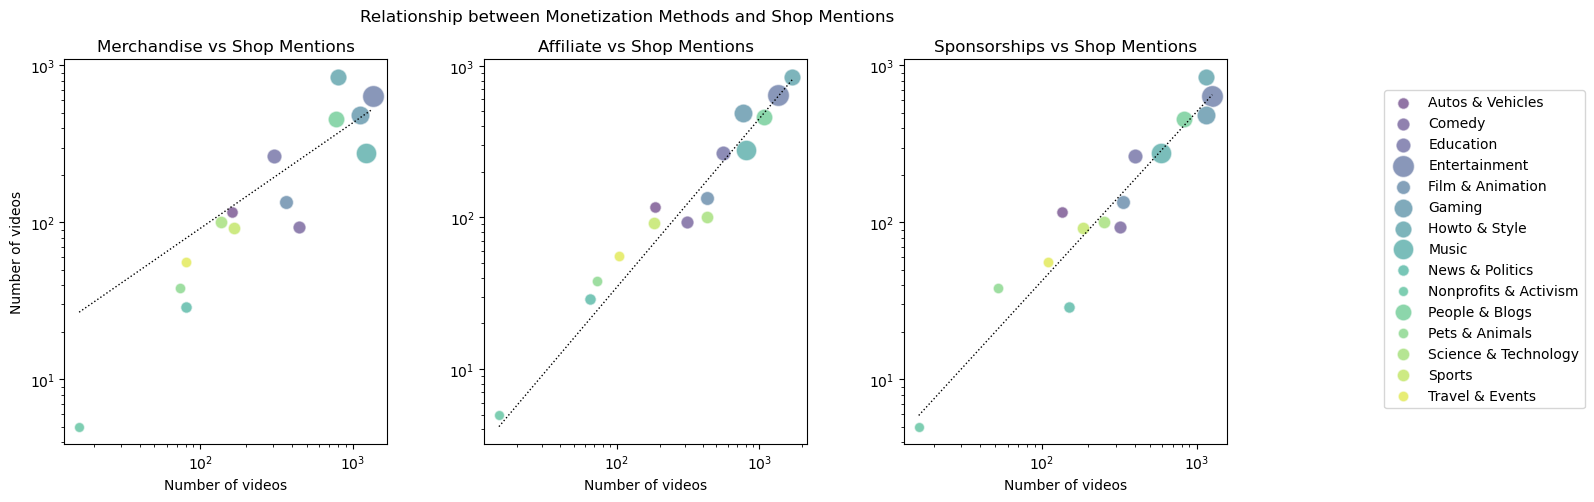

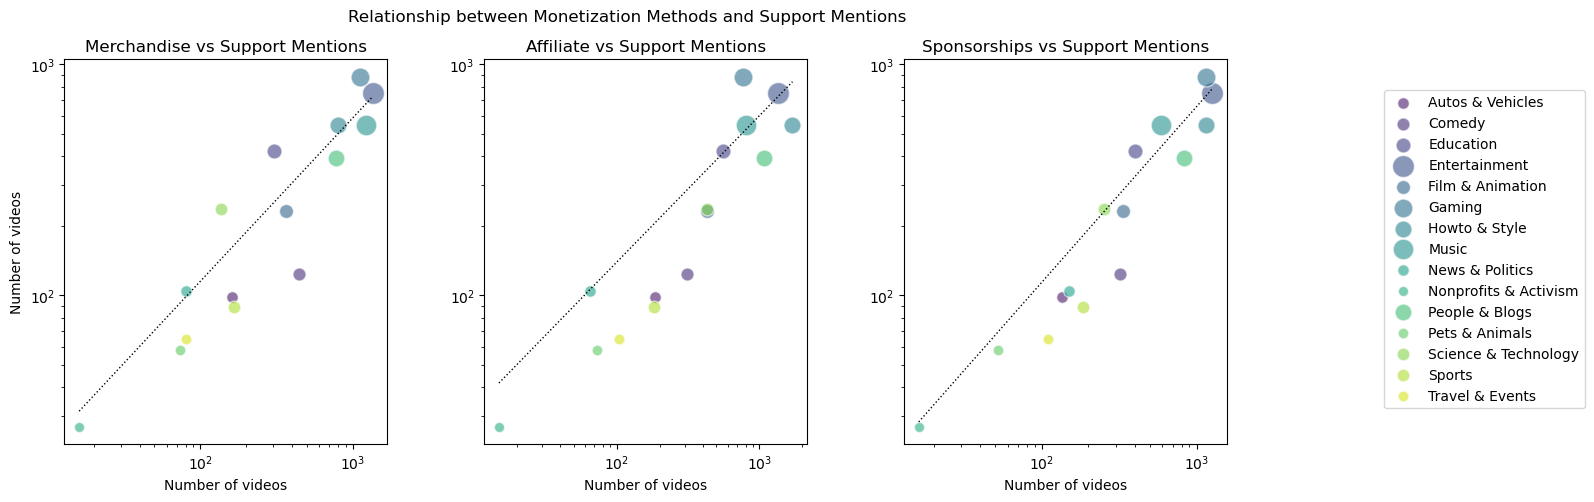

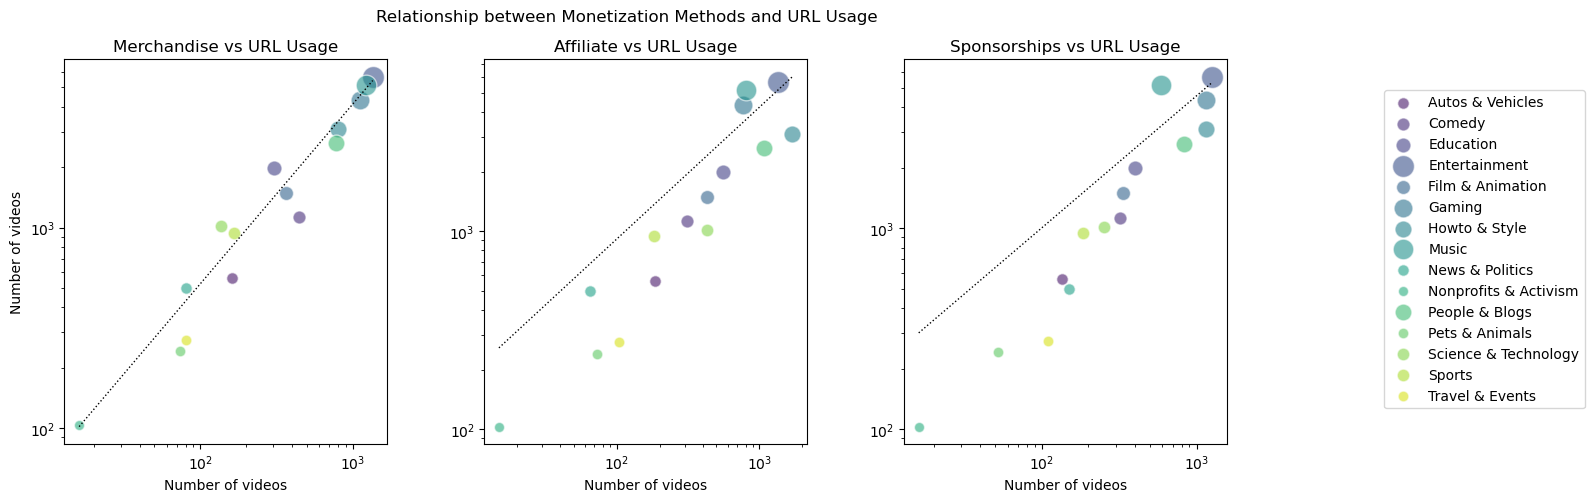

In [29]:
metrics_config = {
    'has_ad': 'Ad Mentions',
    'has_shop': 'Shop Mentions',
    'has_support': 'Support Mentions',
    'has_http': 'URL Usage'
}
merged_dataset = prepare_data(df_cross, df_sizes)
figures = create_visualization(merged_dataset, metrics_config, color_norm=color_map)

# Display all figures
plt.show()

In [30]:
analyze_all_regressions(merged_dataset, metrics_config)


Analyzing regressions for Ad Mentions:

Regression stats for has_merchandise vs has_ad:
Weighted R²: 0.9152
P-value: 8.0995e-01

Regression stats for has_affiliate vs has_ad:
Weighted R²: 0.6915
P-value: 9.2520e-01

Regression stats for has_sponsorships vs has_ad:
Weighted R²: 0.6889
P-value: 9.3226e-01

Analyzing regressions for Shop Mentions:

Regression stats for has_merchandise vs has_shop:
Weighted R²: 0.6647
P-value: 9.3335e-01

Regression stats for has_affiliate vs has_shop:
Weighted R²: 0.9146
P-value: 8.0017e-01

Regression stats for has_sponsorships vs has_shop:
Weighted R²: 0.9094
P-value: 8.1781e-01

Analyzing regressions for Support Mentions:

Regression stats for has_merchandise vs has_support:
Weighted R²: 0.7750
P-value: 8.9963e-01

Regression stats for has_affiliate vs has_support:
Weighted R²: 0.6709
P-value: 9.3123e-01

Regression stats for has_sponsorships vs has_support:
Weighted R²: 0.8155
P-value: 8.9351e-01

Analyzing regressions for URL Usage:

Regression stat

When examining these charts, a clear linear trend emerges, prompting the addition of a weighted linear regression to the visuals. This reveals very strong correlations between the use of merchandise and the appearance of terms like "ad" and URLs in descriptions. Similarly, a strong correlation is observed between affiliation and mentions of "shop." While other correlation coefficients are also high, they are somewhat less pronounced.  

However, due to the small sample size (a result of aggregated category processing), the p-values are significant, making it unreasonable to infer any causal relationships. Nevertheless, it’s evident that a deliberate use of the description space and effective monetization strategies are strongly intertwined on YouTube.  

Additionally, consistent with earlier observations, dominant categories continue to lead the way, often appearing in the upper-right corner of the charts. However, smaller categories like **How-To & Style** occasionally compete with larger ones, as suggested in the initial analysis.

## Outcomes

This study highlights that YouTube’s professionalization is a multifaceted process driven by distinct dynamics across content categories. Categories such as Entertainment, Music, Gaming, and People & Blogs dominate in both content volume and the adoption of monetization strategies. However, smaller categories like How-To & Style demonstrate a unique reliance on external monetization methods, such as affiliation and sponsorship, emphasizing their adaptability and commercial potential despite lower content output.

The findings underscore that professional practices—particularly the use of video descriptions for revenue generation—have become increasingly sophisticated. The rising prominence of terms like “shop,” “support,” and “ad” in video descriptions illustrates a growing trend of creators leveraging this space to drive financial engagement. Strong correlations between monetization strategies and descriptive markers like hyperlinks further solidify the description space as a cornerstone of YouTube’s professionalization.

Overall, this study reveals that YouTube’s professionalization is both dynamic and category-specific, with dominant and emerging content categories shaping its evolution in complementary ways.

---
---

# RQ3: How has creator content strategy evolved to reflect professional monetization approaches?

This analysis examines how creators adapt their content strategies as they transition toward monetization, leveraging the Youniverse dataset that combines channel metadata with temporal engagement metrics. Our methodological approach consist in analyzing the evolutionary trajectories of content creators, focusing specifically on the relationship between strategic changes and monetization patterns.
We begin by processing longitudinal data from Youniverse, extracting key temporal metrics including views, subscribers, upload patterns, and video durations. 

By cross-referencing the time evolution of these metrics with monetization data derived from the description column of the channel metadata, we can pinpoint specific strategic shifts that coincide with monetization milestones. 

We conduct detailed temporal analysis of their metrics and content strategies, revealing how creators systematically modify their approach as they transition toward professional content production.
This framework provides insights into how content creators evolve their strategies to support monetization, potentially revealing successful patterns in the progression from hobbyist to professional content creation. The findings will contribute to our understanding of professional development patterns in digital content creation and identify key strategic adaptations that accompany successful monetization approaches.

We start by loading the time serie data

To analyze monetization patterns, we extracted revenue stream indicators from video descriptions in the yt_metadata_en.jsonl.gz dataset. Our keyword detection system identified five distinct monetization categories:

- Membership: Identified through terms like "subscription," "member," "join button," "channel member," "membership," and "premium content," indicating direct viewer support through recurring payments.
- Crowdfunding: Detected using keywords such as "patreon," "ko-fi," "donation," "support us," "buy me a coffee," "gofundme," "paypal," "tip jar," and "patron," representing various forms of audience financial support.
- Merchandise: Tracked through terms including "merchandise," "merch," "shop," "store," "tshirt," "t-shirt," "hoodie," "apparel," and "limited edition," signaling product-based revenue.
- Sponsorship: Recognized via keywords like "sponsor," "sponsored," "partnership," "partner," "paid promotion," "#ad," "#sponsored," and "promotion," indicating brand collaboration revenue.
- Affiliate Marketing: Identified through terms such as "affiliate," "amazon link," "discount code," "promo code," "referral," "use code," and "commission," representing commission-based income.
We found that mseveral channels have mcombinations of these monetization types such youtube membership and anlternative types (crowdfunding, merchandise, sponsorship, affiliate).

In [4]:
data_path = "data/"
df = pd.read_csv(os.path.join(data_path, "df_yt_monetization.csv"), sep=",")
df

Unnamed: 0                channel_id  duration upload_date  \
0                  0  UCzWrhkg9eK5I8Bm3HfV-unA      1159  2016-09-28   
1                  1  UCzWrhkg9eK5I8Bm3HfV-unA      2681  2016-09-28   
2                  2  UCzWrhkg9eK5I8Bm3HfV-unA      1394  2016-09-28   
3                  3  UCzWrhkg9eK5I8Bm3HfV-unA      5064  2016-09-28   
4                  4  UCzWrhkg9eK5I8Bm3HfV-unA      3554  2016-09-28   
...              ...                       ...       ...         ...   
72924789    72924789  UCrwE8kVqtIUVUzKui2WVpuQ       270  2017-02-06   
72924790    72924790  UCrwE8kVqtIUVUzKui2WVpuQ       878  2017-02-06   
72924791    72924791  UCrwE8kVqtIUVUzKui2WVpuQ      1003  2017-02-06   
72924792    72924792  UCrwE8kVqtIUVUzKui2WVpuQ       755  2017-02-06   
72924793    72924793  UCrwE8kVqtIUVUzKui2WVpuQ      1771  2017-02-06   

            monetization_types  
0                         none  
1                         none  
2                         none  
3                         none  
4                         none  
...                        ...  
72924789            membership  
72924790            membership  
72924791            membership  
72924792  affiliate|membership  
72924793            membership  

[72924794 rows x 5 columns]

## "The Weekly Video Production Journey - Before and After Monetization"

This time series visualization captures the dramatic story of how creators transform their production habits around monetization. 

The graph uses a vertical red line to mark the monetization date, with weeks before and after shown on the x-axis. 
The blue line represents the average weekly change in video count, while the shaded area shows the 95% confidence interval. 

This is essentially a before-and-after portrait of creator productivity, showing how the transition to professional content creation reshapes production patterns.

/var/folders/05/9v_chqnd12v90dtrbyb3b5sc0000gn/T/ipykernel_11409/4030157191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeseries_cleaned['date'] = pd.to_datetime(df_timeseries_cleaned['datetime']).dt.date


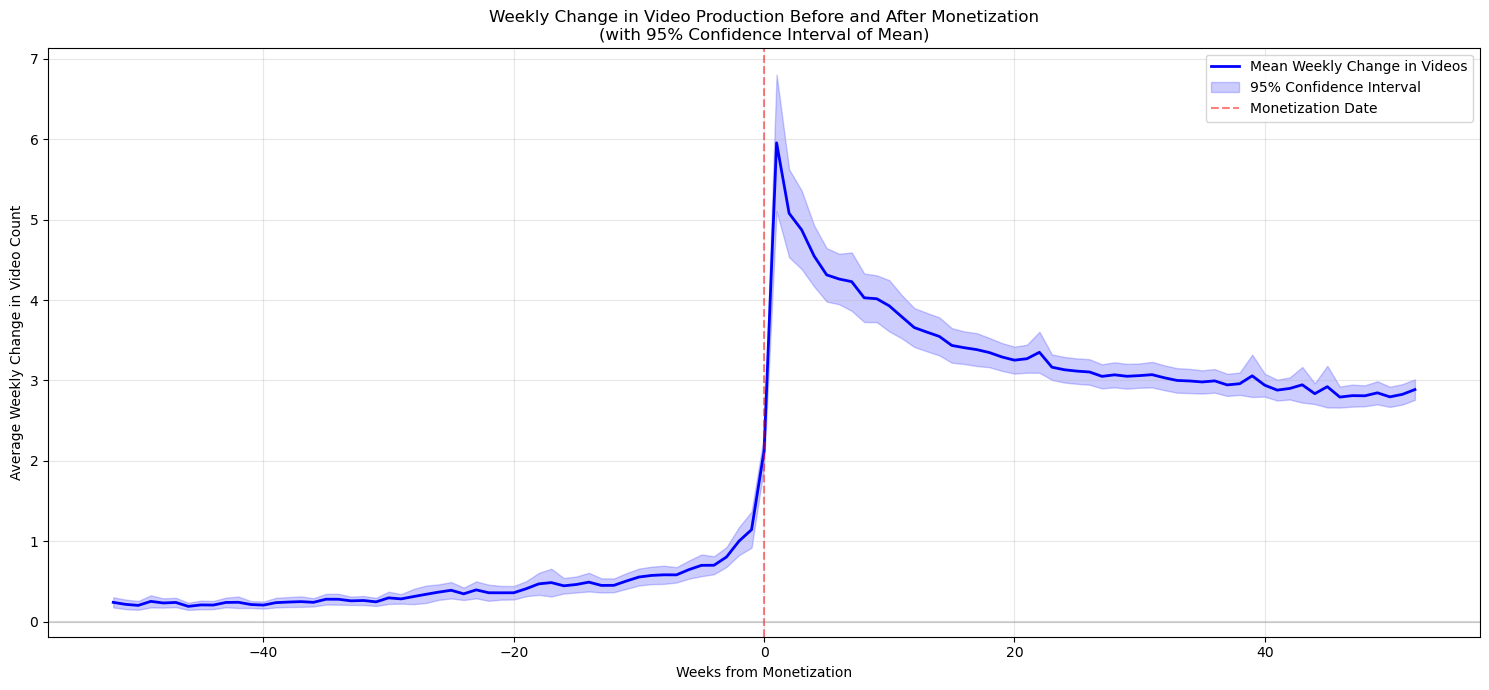


Summary Statistics (Weekly Changes):
--------------------------------------------------

3 months before:
Average weekly change: 0.85
95% CI: (0.81, 0.89)
Number of observations: 189094
Number of channels: 19209

3 months after:
Average weekly change: 4.19
95% CI: (4.09, 4.30)
Number of observations: 390641
Number of channels: 38285

6 months before:
Average weekly change: 0.68
95% CI: (0.65, 0.70)
Number of observations: 317463
Number of channels: 19350

6 months after:
Average weekly change: 3.71
95% CI: (3.66, 3.77)
Number of observations: 894546
Number of channels: 47317


In [7]:
# First find the earliest monetization date per channel
first_monetization = df_monetization[df_monetization['monetization_types'] != 'none'].groupby('channel_id')['upload_date'].min().reset_index()
first_monetization.columns = ['channel', 'first_monetization_date']

# Convert timeseries datetime column to date format for merging
df_timeseries_cleaned['date'] = pd.to_datetime(df_timeseries_cleaned['datetime']).dt.date

# Merge the datasets
merged_df = pd.merge(df_timeseries_cleaned, first_monetization, on='channel', how='left')

# Calculate weeks from monetization
merged_df['weeks_from_monetization'] = (pd.to_datetime(merged_df['date']) - 
                                      pd.to_datetime(merged_df['first_monetization_date'])).dt.days // 7

# Focus on a window of 52 weeks before and after monetization
window_df = merged_df[merged_df['weeks_from_monetization'].between(-52, 52)]

# Calculate weekly stats - modified approach
weekly_means = window_df.groupby('weeks_from_monetization')['delta_videos'].mean()
weekly_counts = window_df.groupby('weeks_from_monetization')['delta_videos'].count()
weekly_sems = window_df.groupby('weeks_from_monetization')['delta_videos'].apply(lambda x: stats.sem(x, nan_policy='omit'))

# Create the statistics dataframe
weekly_stats = pd.DataFrame({
    'mean': weekly_means,
    'count': weekly_counts,
    'sem': weekly_sems
})
weekly_stats = weekly_stats.reset_index()

# Calculate confidence intervals
weekly_stats['ci_lower'] = weekly_stats['mean'] - 1.96 * weekly_stats['sem']
weekly_stats['ci_upper'] = weekly_stats['mean'] + 1.96 * weekly_stats['sem']

# Plotting
plt.figure(figsize=(15, 7))

# Plot mean line
plt.plot(weekly_stats['weeks_from_monetization'], 
         weekly_stats['mean'], 
         color='blue', 
         linewidth=2,
         label='Mean Weekly Change in Videos')

# Add 95% confidence interval bands
plt.fill_between(weekly_stats['weeks_from_monetization'],
                weekly_stats['ci_lower'],
                weekly_stats['ci_upper'],
                color='blue',
                alpha=0.2,
                label='95% Confidence Interval')

# Add vertical line at monetization date
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Monetization Date')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Formatting
plt.title('Weekly Change in Video Production Before and After Monetization\n(with 95% Confidence Interval of Mean)')
plt.xlabel('Weeks from Monetization')
plt.ylabel('Average Weekly Change in Video Count')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (Weekly Changes):")
print("-" * 50)
periods = {
    "3 months before": (-12, 0),
    "3 months after": (0, 12),
    "6 months before": (-24, 0),
    "6 months after": (0, 24)
}

for period, (start, end) in periods.items():
    period_data = window_df[window_df['weeks_from_monetization'].between(start, end)]
    mean = period_data['delta_videos'].mean()
    n = len(period_data)
    se = stats.sem(period_data['delta_videos'], nan_policy='omit')
    ci_lower = mean - 1.96 * se
    ci_upper = mean + 1.96 * se
    
    print(f"\n{period}:")
    print(f"Average weekly change: {mean:.2f}")
    print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
    print(f"Number of observations: {n}")
    print(f"Number of channels: {period_data['channel'].nunique()}")

This graph narrates the dramatic transformation in content production habits around monetization. 

The pre-monetization period shows remarkably stable but low production levels, hovering around 0.5 videos per week. 
This baseline suggests a casual, hobby-like approach to content creation. 
The monetization date marks a seismic shift with production skyrocketting to 6 videos per week, a 1200% increase. 
This initial surge reflects creators' immediate response to monetization incentives, possibly driven by a combination of enthusiasm and perceived pressure to maximize revenue potential. 
What follows is equally telling a gradual decline to about 3 videos per week, suggesting creators finding their sustainable rhythm. The narrowing confidence intervals over time indicate increasing professionalization with creators moving from sporadic posting to consistent, predictable production schedules. 

This entire curve represents the journey from casual creator to content professional.

## "The Evolution of Video Duration - A Quality Investment Timeline"

This longitudinal analysis tracks how creators invest in content depth over time, centered around their monetization date. It uses a time series format with the monetization date marked by a red vertical line. The blue line tracks mean video duration in seconds, with the shaded area representing the 95% confidence interval. This visualization tells the story of how creators gradually shift from shorter, possibly more casual content to longer, more in-depth videos as they professionalize their channels.

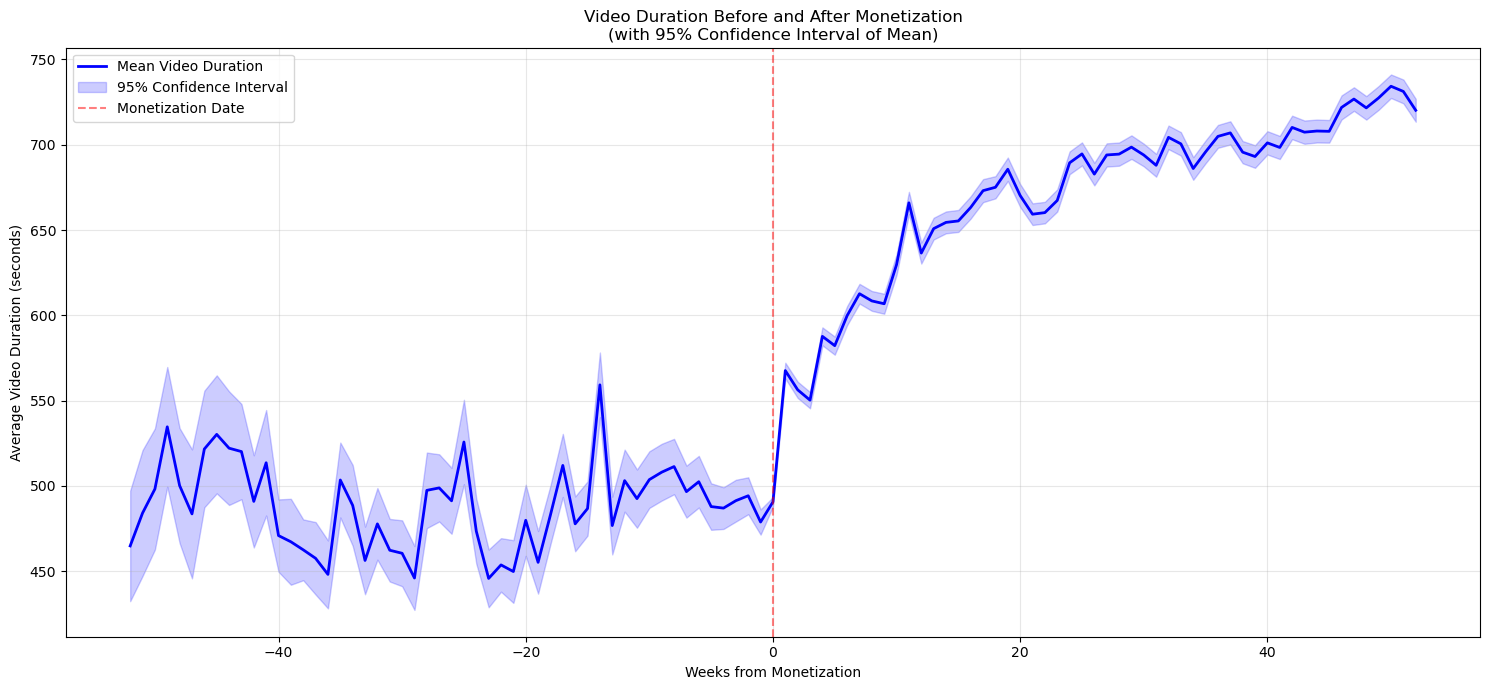


Summary Statistics (Video Duration):
--------------------------------------------------

3 months before:
Average duration: 491.46 seconds
Median duration: 211.00 seconds
95% CI: (489.21, 493.70)
Number of videos: 1385541
Number of channels: 133041

3 months after:
Average duration: 579.01 seconds
Median duration: 225.00 seconds
95% CI: (577.61, 580.40)
Number of videos: 4875237
Number of channels: 133041

6 months before:
Average duration: 490.21 seconds
Median duration: 211.00 seconds
95% CI: (488.14, 492.27)
Number of videos: 1601022
Number of channels: 133041

6 months after:
Average duration: 615.30 seconds
Median duration: 236.00 seconds
95% CI: (614.17, 616.43)
Number of videos: 8302998
Number of channels: 133041

1 year before:
Average duration: 489.75 seconds
Median duration: 211.00 seconds
95% CI: (487.86, 491.65)
Number of videos: 1867559
Number of channels: 133041

1 year after:
Average duration: 658.47 seconds
Median duration: 252.00 seconds
95% CI: (657.62, 659.32)
Numbe

In [8]:
def analyze_duration_around_monetization():
    # First find the earliest monetization date per channel
    first_monetization = df_monetization[df_monetization['monetization_types'] != 'none'].groupby('channel_id')['upload_date'].min().reset_index()
    first_monetization.columns = ['channel', 'first_monetization_date']
    
    # Create date column for merging
    df_monetization['date'] = pd.to_datetime(df_monetization['upload_date']).dt.date
    
    # Merge monetization dates with duration data
    merged_df = pd.merge(df_monetization, first_monetization, 
                        left_on='channel_id', right_on='channel', 
                        how='left')
    
    # Calculate weeks from monetization
    merged_df['weeks_from_monetization'] = (pd.to_datetime(merged_df['date']) - 
                                          pd.to_datetime(merged_df['first_monetization_date'])).dt.days // 7
    
    # Focus on a window of 52 weeks before and after monetization
    window_df = merged_df[merged_df['weeks_from_monetization'].between(-52, 52)]
    
    # Calculate weekly stats
    weekly_means = window_df.groupby('weeks_from_monetization')['duration'].mean()
    weekly_counts = window_df.groupby('weeks_from_monetization')['duration'].count()
    weekly_sems = window_df.groupby('weeks_from_monetization')['duration'].apply(
        lambda x: stats.sem(x, nan_policy='omit')
    )
    
    # Create the statistics dataframe
    weekly_stats = pd.DataFrame({
        'mean': weekly_means,
        'count': weekly_counts,
        'sem': weekly_sems
    })
    weekly_stats = weekly_stats.reset_index()
    
    # Calculate confidence intervals
    weekly_stats['ci_lower'] = weekly_stats['mean'] - 1.96 * weekly_stats['sem']
    weekly_stats['ci_upper'] = weekly_stats['mean'] + 1.96 * weekly_stats['sem']
    
    # Plotting
    plt.figure(figsize=(15, 7))
    
    # Plot mean line
    plt.plot(weekly_stats['weeks_from_monetization'],
             weekly_stats['mean'],
             color='blue',
             linewidth=2,
             label='Mean Video Duration')
    
    # Add 95% confidence interval bands
    plt.fill_between(weekly_stats['weeks_from_monetization'],
                    weekly_stats['ci_lower'],
                    weekly_stats['ci_upper'],
                    color='blue',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    # Add vertical line at monetization date
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Monetization Date')
    
    # Formatting
    plt.title('Video Duration Before and After Monetization\n(with 95% Confidence Interval of Mean)')
    plt.xlabel('Weeks from Monetization')
    plt.ylabel('Average Video Duration (seconds)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics (Video Duration):")
    print("-" * 50)
    periods = {
        "3 months before": (-12, 0),
        "3 months after": (0, 12),
        "6 months before": (-24, 0),
        "6 months after": (0, 24),
        "1 year before": (-52, 0),
        "1 year after": (0, 52)
    }
    
    for period, (start, end) in periods.items():
        period_data = window_df[window_df['weeks_from_monetization'].between(start, end)]
        mean = period_data['duration'].mean()
        median = period_data['duration'].median()
        n = len(period_data)
        se = stats.sem(period_data['duration'], nan_policy='omit')
        ci_lower = mean - 1.96 * se
        ci_upper = mean + 1.96 * se
        
        print(f"\n{period}:")
        print(f"Average duration: {mean:.2f} seconds")
        print(f"Median duration: {median:.2f} seconds")
        print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
        print(f"Number of videos: {n}")
        print(f"Number of channels: {period_data['channel_id'].nunique()}")
    
    # Conduct statistical tests
    before_data = window_df[window_df['weeks_from_monetization'].between(-52, -1)]['duration']
    after_data = window_df[window_df['weeks_from_monetization'].between(0, 52)]['duration']
    
    t_stat, p_value = stats.ttest_ind(before_data, after_data, nan_policy='omit')
    
    print("\nStatistical Test:")
    print("-" * 50)
    print("Independent t-test (before vs after monetization):")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    
    # Calculate effect size (Cohen's d)
    d = (after_data.mean() - before_data.mean()) / np.sqrt((after_data.var() + before_data.var()) / 2)
    print(f"Effect size (Cohen's d): {d:.3f}")

# Run the analysis
analyze_duration_around_monetization()

This graph illustrates perhaps the most significant shift in creator strategy - the evolution of content depth and quality. 
Pre-monetization video durations fluctuate around 500 seconds with wide confidence intervals, indicating inconsistent approaches to content length. 
The post-monetization period shows a sustained upward trend in video duration, eventually exceeding 700 seconds. 
Unlike the spike-and-decline pattern seen in production frequency, this increase is gradual and sustained, suggesting a fundamental shift in content philosophy rather than a reactive change. The narrowing confidence intervals post-monetization tell a story of increasing professionalization - creators developing consistent standards for their content length and quality. The steady climb rather than sudden jump implies this was a learning process, with creators gradually discovering that longer, more detailed content better serves their monetized channels. This trend aligns with platform algorithms that tend to favor longer watch times and suggests creators becoming more strategic about engagement metrics.- 

## Subscriber to View Ratio Before and After Monetization:

The relationship between subscribers and views, normalized to show subscribers gained per 1,000 views. The blue line represents the mean weekly subscriber-to-view ratio, while the light blue shaded area shows the 95% confidence interval. The data spans 40 weeks before and after monetization, with the monetization date marked by a red dashed line at week 0. This visualization helps us understand how a channel's ability to convert viewers into subscribers changes throughout their monetization journey.

/var/folders/05/9v_chqnd12v90dtrbyb3b5sc0000gn/T/ipykernel_11409/762919516.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeseries_cleaned['date'] = pd.to_datetime(df_timeseries_cleaned['datetime']).dt.date


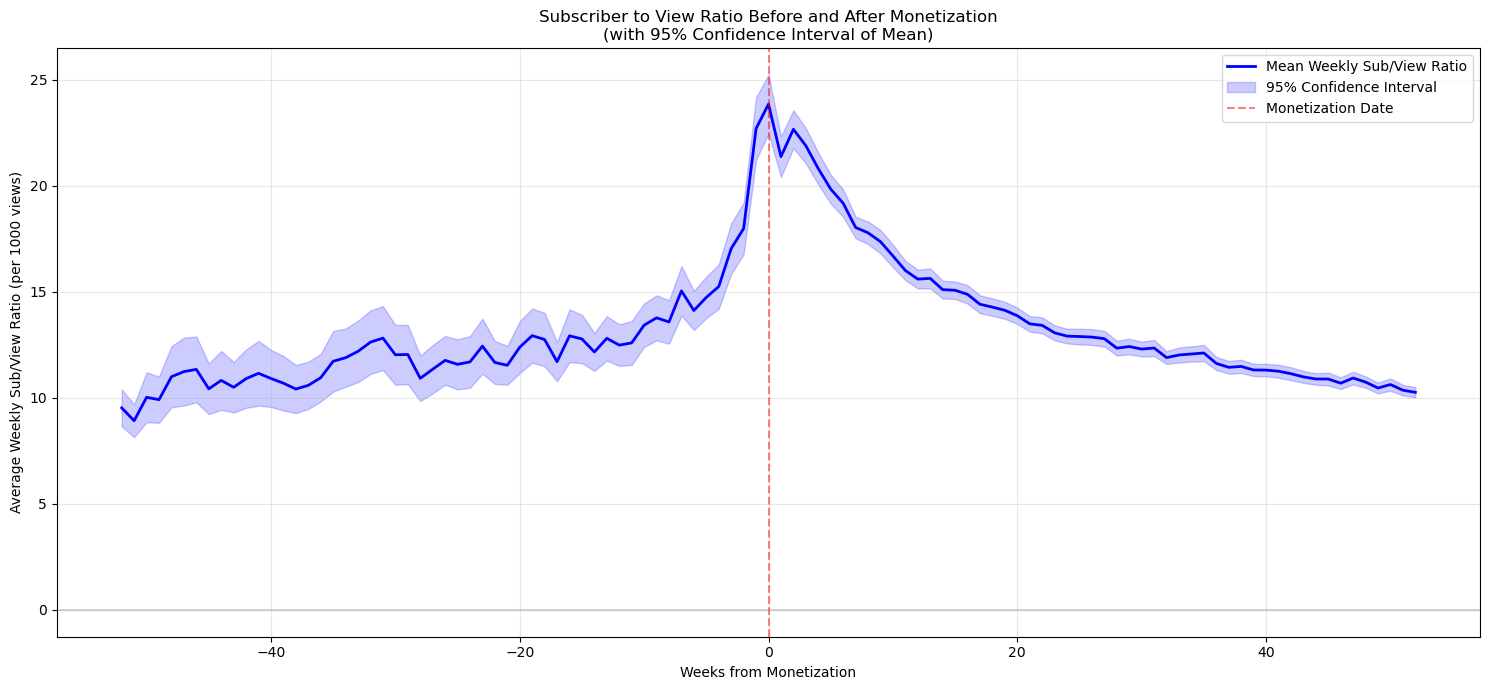


Summary Statistics (Sub/View Ratio):
--------------------------------------------------

3 months before:
Average sub/view ratio: 16.3355
95% CI: (16.0088, 16.6622)
Number of valid observations: 154053
Number of channels: 19209

3 months after:
Average sub/view ratio: 18.7904
95% CI: (18.6081, 18.9728)
Number of valid observations: 354778
Number of channels: 38285

6 months before:
Average sub/view ratio: 14.7311
95% CI: (14.4959, 14.9664)
Number of valid observations: 257332
Number of channels: 19350

6 months after:
Average sub/view ratio: 16.1301
95% CI: (16.0279, 16.2323)
Number of valid observations: 830907
Number of channels: 47317


In [9]:
# First find the earliest monetization date per channel
first_monetization = df_monetization[df_monetization['monetization_types'] != 'none'].groupby('channel_id')['upload_date'].min().reset_index()
first_monetization.columns = ['channel', 'first_monetization_date']

# Convert timeseries datetime column to date format for merging
df_timeseries_cleaned['date'] = pd.to_datetime(df_timeseries_cleaned['datetime']).dt.date

# Merge the datasets
merged_df = pd.merge(df_timeseries_cleaned, first_monetization, on='channel', how='left')

# Calculate weeks from monetization
merged_df['weeks_from_monetization'] = (pd.to_datetime(merged_df['date']) - 
                                      pd.to_datetime(merged_df['first_monetization_date'])).dt.days // 7

# Calculate subscriber to views ratio with better handling of edge cases
# Filter out rows where delta_views is 0 or very small
merged_df['sub_view_ratio'] = np.where(
    (merged_df['delta_views'] > 100),  # Only consider significant view changes
    (merged_df['delta_subs'] / merged_df['delta_views']) * 1000,
    np.nan
)

# Remove infinite values and extreme outliers
merged_df['sub_view_ratio'] = merged_df['sub_view_ratio'].replace([np.inf, -np.inf], np.nan)
# Remove outliers beyond 3 standard deviations
z_scores = stats.zscore(merged_df['sub_view_ratio'].dropna())
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
merged_df.loc[merged_df['sub_view_ratio'].notna(),'sub_view_ratio'] = \
    merged_df.loc[merged_df['sub_view_ratio'].notna(),'sub_view_ratio'][filtered_entries]

# Focus on a window of 52 weeks before and after monetization
window_df = merged_df[merged_df['weeks_from_monetization'].between(-52, 52)]

# Calculate weekly stats for the ratio
weekly_means = window_df.groupby('weeks_from_monetization')['sub_view_ratio'].mean()
weekly_counts = window_df.groupby('weeks_from_monetization')['sub_view_ratio'].count()
weekly_sems = window_df.groupby('weeks_from_monetization')['sub_view_ratio'].apply(lambda x: stats.sem(x, nan_policy='omit'))

# Create the statistics dataframe
weekly_stats = pd.DataFrame({
    'mean': weekly_means,
    'count': weekly_counts,
    'sem': weekly_sems
})
weekly_stats = weekly_stats.reset_index()

# Calculate confidence intervals
weekly_stats['ci_lower'] = weekly_stats['mean'] - 1.96 * weekly_stats['sem']
weekly_stats['ci_upper'] = weekly_stats['mean'] + 1.96 * weekly_stats['sem']

# Plotting
plt.figure(figsize=(15, 7))

# Plot mean line
plt.plot(weekly_stats['weeks_from_monetization'], 
         weekly_stats['mean'], 
         color='blue', 
         linewidth=2,
         label='Mean Weekly Sub/View Ratio')

# Add 95% confidence interval bands
plt.fill_between(weekly_stats['weeks_from_monetization'],
                weekly_stats['ci_lower'],
                weekly_stats['ci_upper'],
                color='blue',
                alpha=0.2,
                label='95% Confidence Interval')

# Add vertical line at monetization date
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Monetization Date')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Formatting
plt.title('Subscriber to View Ratio Before and After Monetization\n(with 95% Confidence Interval of Mean)')
plt.xlabel('Weeks from Monetization')
plt.ylabel('Average Weekly Sub/View Ratio (per 1000 views)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (Sub/View Ratio):")
print("-" * 50)
periods = {
    "3 months before": (-12, 0),
    "3 months after": (0, 12),
    "6 months before": (-24, 0),
    "6 months after": (0, 24)
}

for period, (start, end) in periods.items():
    period_data = window_df[window_df['weeks_from_monetization'].between(start, end)]
    mean = period_data['sub_view_ratio'].mean()
    n = len(period_data['sub_view_ratio'].dropna())  # Count only non-null values
    se = stats.sem(period_data['sub_view_ratio'].dropna(), nan_policy='omit')
    ci_lower = mean - 1.96 * se
    ci_upper = mean + 1.96 * se
    
    print(f"\n{period}:")
    print(f"Average sub/view ratio: {mean:.4f}")
    print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")
    print(f"Number of valid observations: {n}")
    print(f"Number of channels: {period_data['channel'].nunique()}")

The data reveals several fascinating patterns in subscriber acquisition efficiency.
Before monetization, channels maintained a relatively stable ratio of around 10-12 subscribers per 1,000 views, with some minor fluctuations. 

However, the most striking feature is the dramatic spike that occurs around the monetization date, where the ratio surges to approximately 23 subscribers per 1,000 views - nearly double the pre-monetization average. 
This peak is followed by a gradual but consistent decline over the subsequent 40 weeks, eventually returning to roughly the pre-monetization levels of about 10 subscribers per 1,000 views. 
This pattern suggests that monetization creates a temporary boost in subscriber conversion, possibly due to increased creator investment in content quality or changes in audience engagement behavior, but this effect diminishes over time as the channel matures. 

The narrowing confidence interval after monetization also indicates more consistent performance across different channels in the long term.

## "The Monetization Strategy Breakdown - A Cross-Section of Creator Approaches"

We provide a comprehensive snapshot of how different monetization strategies shape creator behavior. By comparing affiliate marketing, membership programs, merchandise sales, non-monetized channels, and other revenue models across four key metrics (uploads, views, subscribers, and video duration), we can see how creators optimize their content strategy based on their primary revenue source. Think of this as a creator's strategic playbook - each monetization type creates its own distinct pattern of behavior and success metrics.

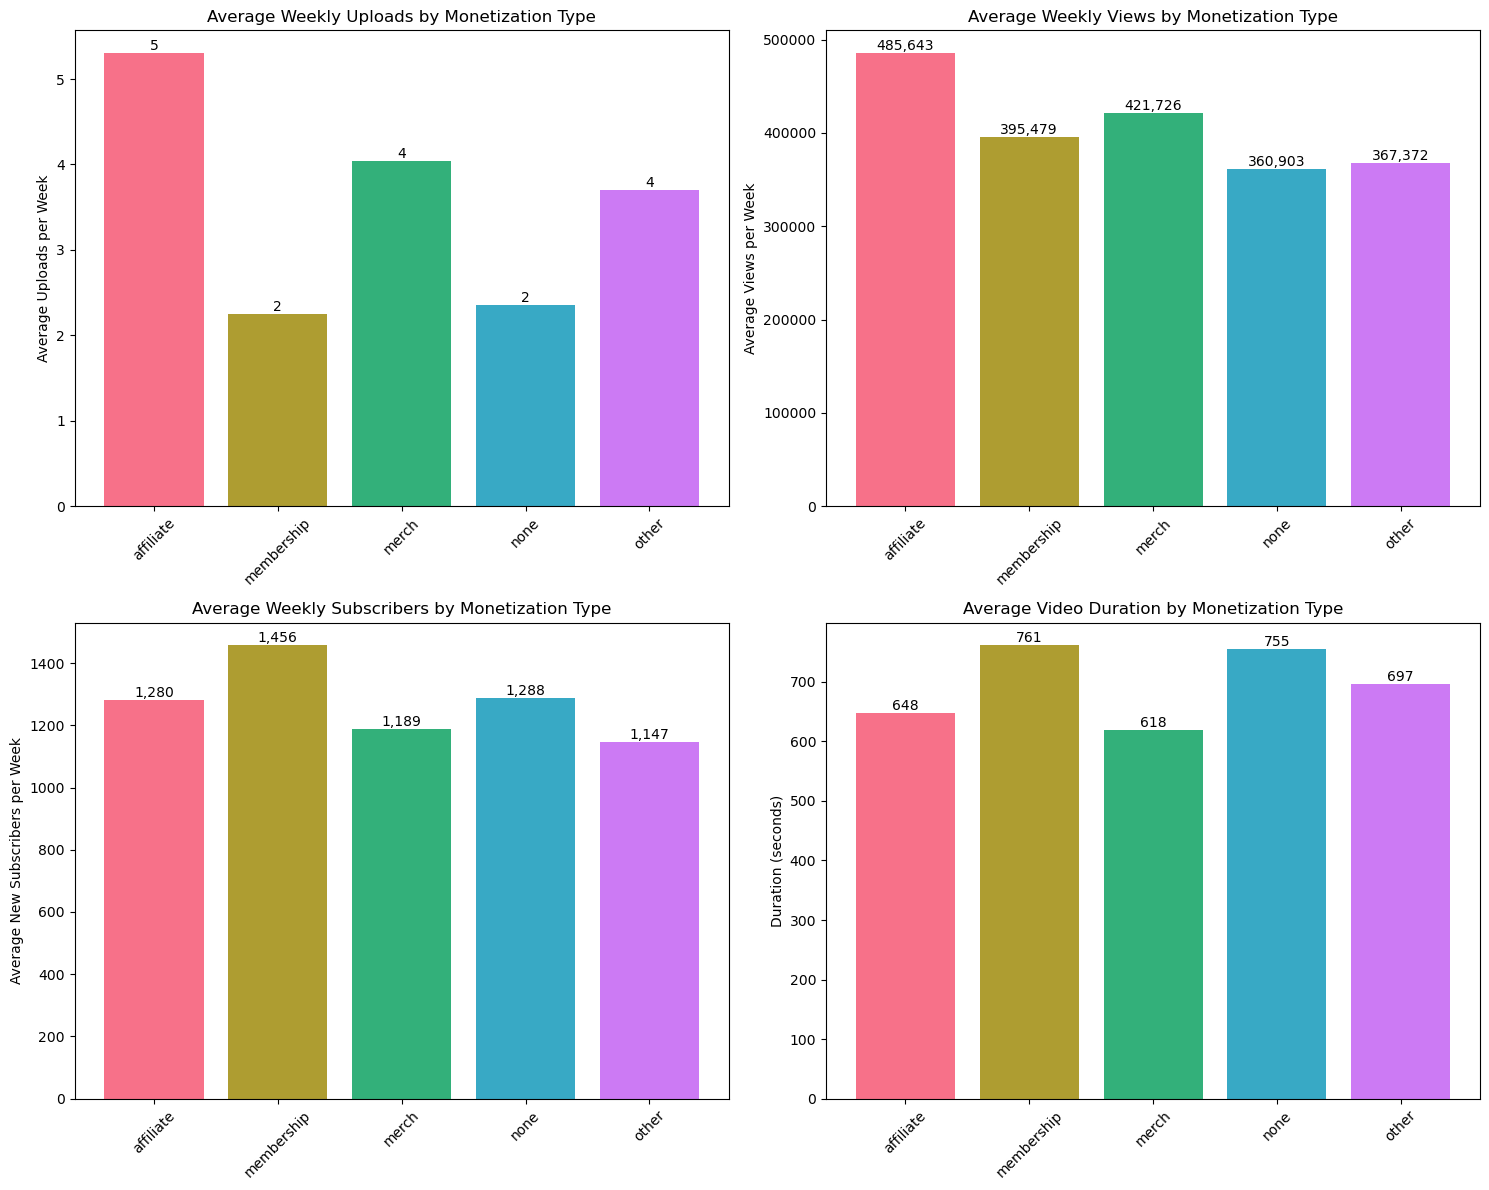


Detailed Statistics by Main Monetization Type:

Monetization Type: affiliate
--------------------------------------------------
Number of Channels: 17,806

Uploads:
  Average per week: 5.30
  Median per week: 1.45

Views:
  Average per week: 485,643
  Median per week: 51,500

Subscribers:
  Average per week: 1279.94
  Median per week: 179.95

Video Duration:
  Average: 648 seconds
  Median: 215 seconds

Monetization Type: membership
--------------------------------------------------
Number of Channels: 132,295

Uploads:
  Average per week: 2.25
  Median per week: 0.76

Views:
  Average per week: 395,479
  Median per week: 54,766

Subscribers:
  Average per week: 1456.38
  Median per week: 256.59

Video Duration:
  Average: 761 seconds
  Median: 286 seconds

Monetization Type: merch
--------------------------------------------------
Number of Channels: 24,653

Uploads:
  Average per week: 4.04
  Median per week: 1.24

Views:
  Average per week: 421,726
  Median per week: 50,557

Subscr

In [10]:
def analyze_trends_by_main_monetization_types():
    """
    Analyzes trends in uploads, views, subscribers, and duration across main monetization types
    """
    # Create simplified monetization categories
    def simplify_monetization_type(mon_type):
        if pd.isna(mon_type) or mon_type == 'none':
            return 'none'
        elif 'membership' in mon_type:
            return 'membership'
        elif 'affiliate' in mon_type:
            return 'affiliate'
        elif 'merch' in mon_type:
            return 'merch'
        elif 'superchat' in mon_type:
            return 'superchat'
        else:
            return 'other'
    
    # Create copy of monetization data with simplified categories
    df_mon_simplified = df_monetization.copy()
    df_mon_simplified['main_monetization'] = df_mon_simplified['monetization_types'].apply(simplify_monetization_type)
    
    # Analyze metrics for each main type
    def analyze_metrics_for_type(mon_type):
        # Get channels with this monetization type
        channels = df_mon_simplified[df_mon_simplified['main_monetization'] == mon_type]['channel_id'].unique()
        
        # Get timeseries data for these channels
        channel_data = df_timeseries_cleaned[df_timeseries_cleaned['channel'].isin(channels)]
        
        # Get duration data
        duration_data = df_mon_simplified[df_mon_simplified['channel_id'].isin(channels)]['duration']
        
        # Calculate metrics
        metrics = {
            'num_channels': len(channels),
            'avg_uploads_per_week': channel_data.groupby('channel')['delta_videos'].mean().mean(),
            'med_uploads_per_week': channel_data.groupby('channel')['delta_videos'].mean().median(),
            'avg_views_per_week': channel_data.groupby('channel')['delta_views'].mean().mean(),
            'med_views_per_week': channel_data.groupby('channel')['delta_views'].mean().median(),
            'avg_subs_per_week': channel_data.groupby('channel')['delta_subs'].mean().mean(),
            'med_subs_per_week': channel_data.groupby('channel')['delta_subs'].mean().median(),
            'avg_duration': duration_data.mean(),
            'med_duration': duration_data.median(),
            'total_channels': len(channels)
        }
        
        return metrics
    
    # Get main monetization types
    main_types = sorted(df_mon_simplified['main_monetization'].unique())
    
    # Calculate metrics for each main type
    results = {mon_type: analyze_metrics_for_type(mon_type) 
              for mon_type in main_types if pd.notna(mon_type)}
    
    # Create visualization subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Colors for consistency
    colors = sns.color_palette("husl", len(results))
    
    # Helper function for plotting
    def plot_metric(ax, metric_name, title, ylabel):
        data = {k: v[metric_name] for k, v in results.items()}
        ax.bar(data.keys(), data.values(), color=colors)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on top of bars
        for i, v in enumerate(data.values()):
            ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom')
    
    # 1. Uploads Analysis
    plot_metric(ax1, 'avg_uploads_per_week', 
               'Average Weekly Uploads by Monetization Type',
               'Average Uploads per Week')
    
    # 2. Views Analysis
    plot_metric(ax2, 'avg_views_per_week',
               'Average Weekly Views by Monetization Type',
               'Average Views per Week')
    
    # 3. Subscribers Analysis
    plot_metric(ax3, 'avg_subs_per_week',
               'Average Weekly Subscribers by Monetization Type',
               'Average New Subscribers per Week')
    
    # 4. Duration Analysis
    plot_metric(ax4, 'avg_duration',
               'Average Video Duration by Monetization Type',
               'Duration (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nDetailed Statistics by Main Monetization Type:")
    print("=" * 80)
    
    for mon_type, metrics in results.items():
        print(f"\nMonetization Type: {mon_type}")
        print("-" * 50)
        print(f"Number of Channels: {metrics['num_channels']:,}")
        print("\nUploads:")
        print(f"  Average per week: {metrics['avg_uploads_per_week']:.2f}")
        print(f"  Median per week: {metrics['med_uploads_per_week']:.2f}")
        print("\nViews:")
        print(f"  Average per week: {metrics['avg_views_per_week']:,.0f}")
        print(f"  Median per week: {metrics['med_views_per_week']:,.0f}")
        print("\nSubscribers:")
        print(f"  Average per week: {metrics['avg_subs_per_week']:.2f}")
        print(f"  Median per week: {metrics['med_subs_per_week']:.2f}")
        print("\nVideo Duration:")
        print(f"  Average: {metrics['avg_duration']:.0f} seconds")
        print(f"  Median: {metrics['med_duration']:.0f} seconds")
    
    # Statistical Analysis
    print("\nStatistical Analysis:")
    print("=" * 80)
    
    metrics_to_test = {
        'delta_videos': 'uploads',
        'delta_views': 'views',
        'delta_subs': 'subscribers'
    }
    
    for metric, name in metrics_to_test.items():
        print(f"\nKruskal-Wallis H-test for {name}:")
        # Gather data for each monetization type
        data_by_type = []
        labels = []
        for mon_type in main_types:
            channels = df_mon_simplified[df_mon_simplified['main_monetization'] == mon_type]['channel_id'].unique()
            metric_data = df_timeseries_cleaned[df_timeseries_cleaned['channel'].isin(channels)][metric].values
            data_by_type.append(metric_data)
            labels.append(mon_type)
        
        # Perform Kruskal-Wallis H-test
        h_stat, p_val = stats.kruskal(*data_by_type)
        print(f"H-statistic: {h_stat:.3f}")
        print(f"p-value: {p_val:.4f}")

# Run the analysis
analyze_trends_by_main_monetization_types()

Our analysis reveals distinct patterns in how channels evolve with different monetization strategies. Affiliate-monetized channels stand out as the most prolific content producers, averaging 5 uploads per week - more than double the rate of membership-focused channels (2 uploads) and significantly higher than non-monetized channels (2 uploads). This suggests that affiliate partnerships may incentivize more frequent content creation, possibly due to the need to regularly showcase products or services.

When it comes to viewership, affiliate channels also lead the pack, garnering an average of 485,643 weekly views, followed by merchandise-focused channels with 421,726 views. This indicates that affiliate content tends to attract larger audiences, perhaps due to the combination of regular uploads and product-focused content that often aligns with viewer interests and search patterns.

However, the subscriber story tells a different tale. Membership-based channels, despite posting less frequently, achieve the highest weekly subscriber growth at 1,456 new subscribers per week. This suggests that while they produce less content, their videos may be of higher quality or provide more value to viewers, encouraging long-term channel commitment.

The duration analysis provides another interesting insight - Membership-based followed by non-monetized channels actually produce longer videos (averaging respectively 761 and 755 seconds) compared to affiliate channels (648 seconds). This could indicate that monetization strategies might influence content length.

Looking at the distributions across channels, we see significant variability within each monetization type, suggesting that success isn't solely tied to monetization strategy. However, the patterns suggest that different monetization approaches might lead to different content strategies:

1. Affiliate channels focus on frequent, shorter content with broad reach
2. Membership channels prioritize subscriber growth through less frequent but potentially more engaging content
3. Merchandise-focused channels maintain a balanced approach between views and engagement and tend toward longer-form content, perhaps focusing more on creative expression.

These findings suggest that successful YouTubers adapt their content strategy to align with their chosen monetization approach, rather than following a one-size-fits-all model. The data also hints at a possible evolution in content strategy as channels mature and diversify their revenue streams, with each monetization type potentially serving different stages of a channel's growth journey.


---
---

# RQ4: How have creators evolved community management from informal interactions to professional engagement strategies, and what video styles are generating the most engagement?

The goal is to help the content creators in the management of their community by identifying strategies to stimulate the engagement of the viewers within the community. To do this, we firstly understand which themes are susceptible to generate the most reactions among the viewers of the community. This will help the content creator to optimise its future content to maintain an active and engaged audience.

Firstly, we analyse interactions within the whole youtube community by studying the comments. The goal is to identify how themes are correlated to each other. For example, if we notice that people who react under videos from the theme A will also react under videos from the theme B but will never react under videos from the theme C, we will thus conclude that themes A and B are close to each other and far from the theme C. Knowing these correlations or "distances" between the themes, we can create clusters of themes, which means groups of themes that often appear together in an author's comments. 

Once themes are grouped together into clusters, it will be easier for the conten creator to indentify which subjects are keen to encourage reactions among its community. Thus the content creator will explore new subjects or deepen some sujects and will also try to collaborate with other content creators that are implied in themes located in the same theme cluster. 

Finally, the contznt creator can now adapt its strategies and its subjects depending on the expectations of the community. This will maintain the audience active and will open new opportunities of partnership. 

We firstly present here the datasets we are using in this task. 

1) youtube_comments.tsv.gz : contains around 8.6 B comments. Each rows corresponds to a comment. It contains an anonymized user id, a video id, the number of replies the comment received, and the number of likes the comment received.

2) yt_metadata_en.jsonl.gz : contains metadata data related to ~73M videos. Each rows correponds to a video. It contains the category of the video, the id of the channel related to the video, the crawl date, the description written by the creator under the video, the number of dislikes, the id of the video, the duration, the number of likes, the tags, the title, the upload date and the view count

We firstly preprocess the data in the following way : 
- Using the "process_comments.py" file, we open the "youtube_comments.tsv.gz" file. We only consider authors who wrote more than 100 comments in total and we keep a list containing the id's of the the videos under which the author commented. We split the "process_comments.py" file in chunks of 100.000.000 lines each and we store each of these chunks in files names "filtered_comments_i.csv" where i goes from 0 to ___.
- Using the "process_metadata.py" file, we read the "yt_metadata_en.jsonl.gz" file. For each row, we only keep the id of the video and the category it belongs to. We store the final data in the "yt_metadata.csv" file.
- Using the "matrix_contruction.py" file, we open the "filtered_comments_i.csv" and "yt_metadata.csv" files and we create based on them a matrix. Each row of the matrix represents an author and each column a category. Noting the matrix $A$, then $A_{ij}$ would be the number of comments the author i wrote unders videos belonging to the category j. The matrix is then stored in the "my_matrix.npy" file.

In [3]:
# Reading data about videos
df_metadata = pd.read_csv("yt_metadata.csv") 

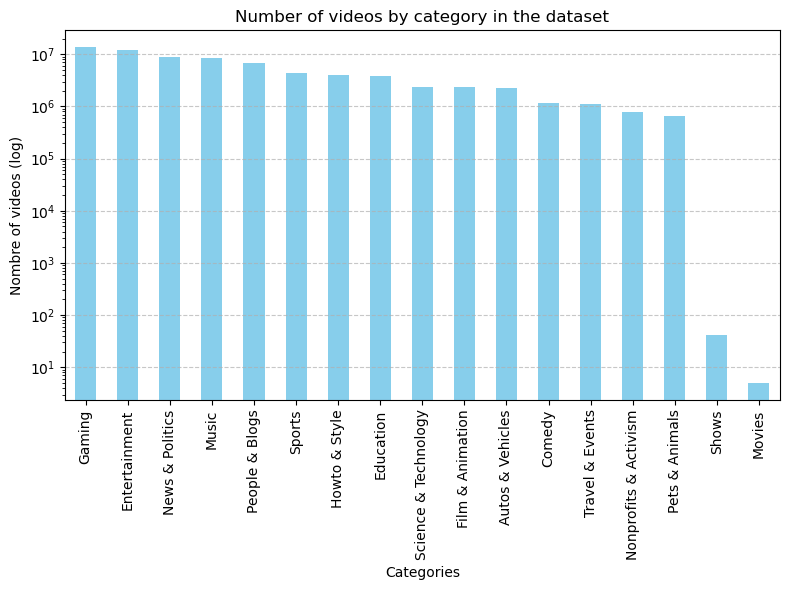

In [4]:
## We visualize here how mush video we have per category

# Counting of the number fo videos
category_counts = df_metadata['Film & Animation'].value_counts()

# Plotting the results
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of videos by category in the dataset')
plt.xlabel('Categories')
plt.ylabel('Nombre of videos (log)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()

As we can see on the plot, there are two categories that are under represented compared with the others in the dataset. It is thus useless to consider these categories in our analysis because there are not enough data about them. The two categories are "Shows" and "Movies". 

In [5]:
category_counts

Gaming                   13720303
Entertainment            12276397
News & Politics           8881022
Music                     8305003
People & Blogs            6910666
Sports                    4354412
Howto & Style             3968127
Education                 3795564
Science & Technology      2403004
Film & Animation          2359735
Autos & Vehicles          2256967
Comedy                    1172503
Travel & Events           1096565
Nonprofits & Activism      777449
Pets & Animals             645508
Shows                          41
Movies                          5
Name: Film & Animation, dtype: int64

In [6]:
## Loading the category matrix and the list of categories

# Loading category matrix to a numpy array
category_matrix = np.load("my_matrix.npy")

# Loading the list of all categories to a numpy array
with open("liste_cat.pkl", "rb") as file:
    liste_categories = pickle.load(file)
liste_categories = liste_categories

In [7]:
# Here we want to dump the columns associated with the Shows and Movies categories
index_shows = np.where(liste_categories == "Shows")[0] # Index of the "Shows" category in the list of categories
index_movies = np.where(liste_categories == "Movies")[0] # Index of the "Movies" category in the list of categories
liste_indices = list(range(len(category_matrix[0])))
liste_indices.remove(index_shows); liste_indices.remove(index_movies)
category_matrix = category_matrix[:, liste_indices]  # Selecting only the relevant categories

Before computing whatever with the matrix $A$ described before, we firstly divide each row by it's $l_1$ norm. For each row i : 
$$ 
A_i \leftarrow \frac{A_i}{||A_i||_{l_1}}
$$
The idea behing this step is to have for each row of the matrix (and thus for each author of comments) a distribution of the themes the author commented. 

At this step, we know have a matrix $A$ such that $A_{ij} = $ distribution of comments written by the author i under videos belonging to the category j. The goal is now to establish a notion of distance between the categories based on this matrix. Let's note $A_{:i}$ the i'th column of the matrix $A$, we describe the distance between the category i and the category j as : 
$$
dist(cat_i, cat_j) = 1 - \frac{A_{:i} \cdot A_{j:}}{||A_{:i}|| ||A_{:j}||}
$$


In [8]:
## We compute in this cell the distances between the categories

# Firstly, we divide each row by its l1 norm 
for i in range(len(category_matrix)) : 
    category_matrix[i] = category_matrix[i]/np.sum(category_matrix[i])

# We then compute the distance matrix
similarity_matrix = cosine_similarity(category_matrix.T)   
distance_matrix = 1 - similarity_matrix
np.save("distance_matrix.npy", distance_matrix)

# We create a dataframe based on this matrix
distance_df = pd.DataFrame(distance_matrix, columns=liste_categories[liste_indices], index = liste_categories[liste_indices])


In [9]:
distance_df.to_csv("distance.csv")

In [10]:
# Interactive heatmap
fig = px.imshow(distance_df,
                labels=dict(x="Categories", y="Categories", color="Distance"),
                x=distance_df.columns,
                y=distance_df.index,
                color_continuous_scale='RdBu',  
                text_auto=".2f")


fig.update_traces(
    hovertemplate="<b>Catégorie 1:</b> %{y}<br>"
                  "<b>Catégorie 2:</b> %{x}<br>"
                  "<b>Distance:</b> %{z:.2f}<extra></extra>"
)


fig.update_layout(
    title="Distance matrix between the categories",
    xaxis=dict(tickangle=-45),
    width=800,
    height=800
)

fig.write_html("matrice_distance.html")  # Saving the interactive matrix to use it in the app project

fig.show()


A short distance in the matrix between two categories A and B means that an author who comments under videos belonging to the category A is likely to comment under videos belonging to the category B and a great distance means that the same author is unlikely to comment under videos of both categories. 

### Closest Categories : 

We can thus know what are the closest categories for each category : 
- Film & Animation      : Entertainment (0.50), Comedy (0.59), Gaming (0.64)
- Gaming                : Entertainment (0.56), Comedy (0.62), Film & Animation (0.64)
- Education             : Entertainment (0.70), News & Politics (0.72), People & Blogs (0.73)
- People & Blogs        : Entertainment (0.42), Comedy (0.51), Howto & Style (0.60)
- Entertainment         : Comedy (0.40), People & Blogs (0.42), Film & Animation (0.50)
- Autos & Vehicles      : Science & Technology (0.87), People & Blogs (0.88), Entertainment (0.89)
- Comedy                : Entertainment (0.40), People & Blogs (0.51), Film & Animation (0.59)
- Sports                : ENtertainment (0.78), People & Blogs (0.84), Gaming (0.85)
- News & Politics       : Education (0.72), Entertainment (0.76), Nonprofits & Activism (0.80)
- Music                 : Entertainment (0.58), Comedy (0.66), People & Blogs (0.71)
- Howto & Style         : People & Blogs (0.60), Entertainment (0.69), Comedy (0.73)
- Science & Technology  : Education (0.77), Gaming (0.78), Entertainment (0.80)
- Travel & Events       : People & Blogs (0.81), Entertainment (0.84), Education (0.87)
- Pets & Animals        : Entertainment (0.81), People & Blogs (0.83), Comedy (0.84)
- Nonprofits & Activism : Education (0.80), News & Politics (0.80), People & Blogs (0.87)

Firstly, we notice that this is not that surprising. It is logical that people who comment content about Nonprofits & Activism will be more likely to comment under content about Education, News & Politics ... and the analysis is the same for the orther categories. 

We also notice that some themes seem to be close to a lot of different themes (for example Entertainment or People & Blog) and others seem to be quite isolated (for example Autos & Vehicles and Nonprofits & Activism). Moreover, Entertainment is in the top 3 of 9 categories while Nonprofits & Activism is in the top 3 of None. We decide to study how isolated is a category compared to the other by computing the mean of the distances of each category. 



In [11]:
distance_df.mean().sort_values()

Entertainment            0.642682
People & Blogs           0.680323
Comedy                   0.692595
Film & Animation         0.737471
Education                0.758838
Gaming                   0.759284
Music                    0.762077
Howto & Style            0.796859
News & Politics          0.804457
Science & Technology     0.811153
Sports                   0.830895
Pets & Animals           0.836359
Travel & Events          0.839529
Nonprofits & Activism    0.852436
Autos & Vehicles         0.859666
dtype: float64

In [12]:
similarity_df = pd.DataFrame(similarity_matrix, columns=liste_categories[liste_indices], index = liste_categories[liste_indices])

Without surprises, we notice that Entertainment, People & Blogs and Comedy are the three categories with the least distance mean woth the other categories. This can be firstly explained by the fact that they are liked by a range variety of people. Indeed, everybody wants to be entertained in some ways and want to laugh in front of comedies whatever are the other contents the perso is consuming. Secondly, this can be explained by the fact that Entertainment, People & Blogs and Comedy are categories that can englobe a lot of different kinds of content. We can entertain people or make them laugh in a lot of different ways that's why different kind of people will still consume this content and react about it in comments. 

In [13]:
df_sim = 1 - distance_df

In [14]:
df_sim.head(20)

Film & Animation    Gaming  Education  People & Blogs  \
Film & Animation               1.000000  0.360991   0.202427        0.328482   
Gaming                         0.360991  1.000000   0.155894        0.283391   
Education                      0.202427  0.155894   1.000000        0.271795   
People & Blogs                 0.328482  0.283391   0.271795        1.000000   
Entertainment                  0.496409  0.437381   0.296395        0.578110   
Autos & Vehicles               0.057436  0.063227   0.098234        0.116711   
Comedy                         0.412233  0.384184   0.218897        0.492275   
Sports                         0.099886  0.152209   0.114772        0.162698   
News & Politics                0.114749  0.071032   0.275164        0.201727   
Music                          0.260923  0.215423   0.167453        0.293333   
Howto & Style                  0.169800  0.100928   0.144634        0.403632   
Science & Technology           0.123677  0.158568   0.234681        0.171332   
Travel & Events                0.088831  0.071498   0.127269        0.191362   
Pets & Animals                 0.147912  0.120857   0.109376        0.167361   
Nonprofits & Activism          0.074178  0.035151   0.200433        0.132938   

                       Entertainment  Autos & Vehicles    Comedy    Sports  \
Film & Animation            0.496409          0.057436  0.412233  0.099886   
Gaming                      0.437381          0.063227  0.384184  0.152209   
Education                   0.296395          0.098234  0.218897  0.114772   
People & Blogs              0.578110          0.116711  0.492275  0.162698   
Entertainment               1.000000          0.110205  0.599712  0.216149   
Autos & Vehicles            0.110205          1.000000  0.072771  0.086526   
Comedy                      0.599712          0.072771  1.000000  0.139778   
Sports                      0.216149          0.086526  0.139778  1.000000   
News & Politics             0.236041          0.078208  0.159909  0.112357   
Music                       0.421284          0.069468  0.342802  0.134877   
Howto & Style               0.305736          0.046599  0.269268  0.059319   
Science & Technology        0.203461          0.134606  0.169727  0.086448   
Travel & Events             0.156452          0.092365  0.105517  0.071081   
Pets & Animals              0.189815          0.044507  0.156926  0.058637   
Nonprofits & Activism       0.112614          0.034141  0.087081  0.041834   

                       News & Politics     Music  Howto & Style  \
Film & Animation              0.114749  0.260923       0.169800   
Gaming                        0.071032  0.215423       0.100928   
Education                     0.275164  0.167453       0.144634   
People & Blogs                0.201727  0.293333       0.403632   
Entertainment                 0.236041  0.421284       0.305736   
Autos & Vehicles              0.078208  0.069468       0.046599   
Comedy                        0.159909  0.342802       0.269268   
Sports                        0.112357  0.134877       0.059319   
News & Politics               1.000000  0.114285       0.064848   
Music                         0.114285  1.000000       0.159393   
Howto & Style                 0.064848  0.159393       1.000000   
Science & Technology          0.121464  0.125947       0.089104   
Travel & Events               0.109073  0.092799       0.089764   
Pets & Animals                0.076986  0.095787       0.093937   
Nonprofits & Activism         0.197297  0.075070       0.050150   

                       Science & Technology  Travel & Events  Pets & Animals  \
Film & Animation                   0.123677         0.088831        0.147912   
Gaming                             0.158568         0.071498        0.120857   
Education                          0.234681         0.127269        0.109376   
People & Blogs                     0.171332         0.191362        0.167361   
Entertainment       

We finish the analysis by simplifying the task to the content creator. We now try to identify clusters of categories based of the distance matrix. For that, we use hierarchical clustering as following : 

In [15]:
# Créer un dendrogramme interactif avec Plotly
fig = ff.create_dendrogram(
    distance_matrix,
    labels=liste_categories[liste_indices],
    orientation='bottom',
    linkagefun=lambda x: linkage(x, 'ward')
)

# Mise en forme du graphique
fig.update_layout(
    title="Categories clustering",
    xaxis_title="Categories",
    yaxis_title="Distance",
    width=1000,
    height=600
)

fig.write_html("dendogramme.html")

# Afficher le dendrogramme interactif
fig.show()


Mid-level clusters seem to be the following : 
- People & Blogs, Entertainment and Comedy
- Music, Film & Animation and Gaming
- Nonprofits & Activism, Education and News & Politics
- Howto & style and Pets & Animals
- Sports, Autos & Vehicles and Science & Technology

---
---

# Conclusion 

The evolution of YouTube content creators' strategies in response to monetization reveals a profound transformation in digital content production. Our analysis demonstrates that the transition from hobby to profession is marked by systematic changes in content strategy, production patterns, and audience engagement approaches.

The data reveals a striking shift in production habits around monetization milestones. Creators typically evolve from sporadic, casual posting schedules to more structured and frequent content delivery, though this eventually settles into a sustainable rhythm that balances productivity with content quality. This is accompanied by a consistent trend toward longer-form content, suggesting a deeper investment in production value and comprehensive subject coverage.

Perhaps most telling is the evolution in audience engagement metrics. The observed spike in subscriber conversion rates immediately following monetization, followed by a gradual normalization, points to a critical period where creators must transition from initial success to sustainable growth. This pattern suggests that while monetization creates immediate opportunities for audience expansion, long-term success requires creators to develop sophisticated engagement strategies.

Different monetization approaches appear to drive distinct content strategies. Affiliate-focused channels tend toward higher-frequency, shorter-form content with broad reach, while membership-based channels often prioritize less frequent but more substantive content that drives stronger subscriber loyalty. These divergent approaches indicate that successful creators adapt their content strategy to align with their chosen revenue model rather than following a universal template.

Community engagement patterns further reflect this maturation of the platform, with clear clustering of content categories based on audience interaction. The strong interconnections between entertainment, lifestyle, and comedy content suggest that successful creators often operate within these overlapping spheres of interest, while more specialized content categories maintain distinct but equally valuable audience relationships.

This research illuminates YouTube's transformation from a casual video-sharing platform into a sophisticated ecosystem for professional content creation. The findings suggest that successful content creators increasingly approach their work with strategic intent, balancing creative expression with audience expectations and platform dynamics. This evolution represents a broader shift in digital content creation, where creator success increasingly depends on the ability to adapt professional strategies while maintaining authentic connections with their audience.